## Clustering Countries based on Socioeconomic Factors

- Project Goal is to cluster countries that are in need of financial aid
- Countries will be clustered based on health and economic factors that will determine the overall development of each country

### Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial.distance import cdist

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score


from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import hypertools as hyp
from collections import Counter

'''Set plotting parameters'''
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Country-data.csv',low_memory=False)
df

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  
0         9.44        56.2       5.82    553  
1         4.49        76.3       1.65   4090  
2        16.10        76.5       2.89   4460  
3        22.40        60.1       6.16   3530  
4         1.44        76.8       2.13  12200  
..         ...         ...        ...    ...  
162       2.62        63.0       3.50   2970  
163      45.90        75.4       2.47  13500  
164      12.10        73.1       1.95   1310  
165      23.60        67.5       4.67   1310  
166      14.00        52.0       5.40   1460  

[167 rows x 10 columns]

In [1]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile

In [4]:
# describe data
print("Describe:\n")
print(df.describe())
print("--------------------------\n")
print("Shape:\n")
print(df.shape)
print("--------------------------\n")
print("Null Values:\n")
print((df.isnull().sum() / len(df)) * 100)
print("--------------------------\n")
print("Info:\n")
print(df.info(verbose=True))

Describe:

       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    

- Big difference in certain values between 75% percentile and max values, giving a hint for outliers that have to be checked
- Negative values of inflation signify that there are periods of deflation in some countries

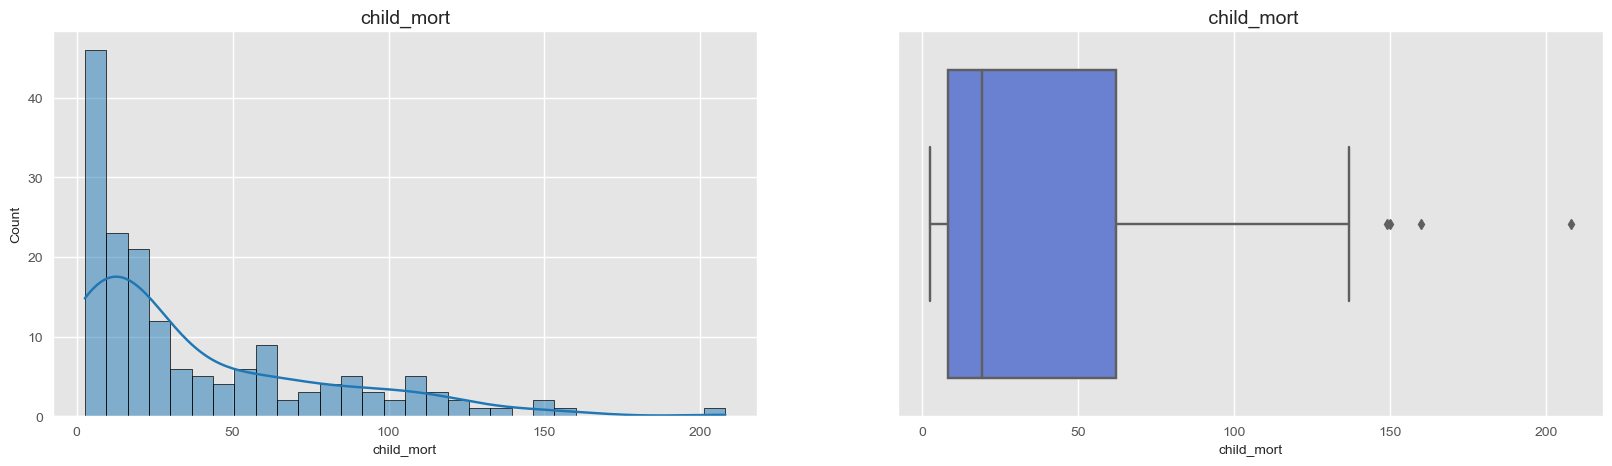

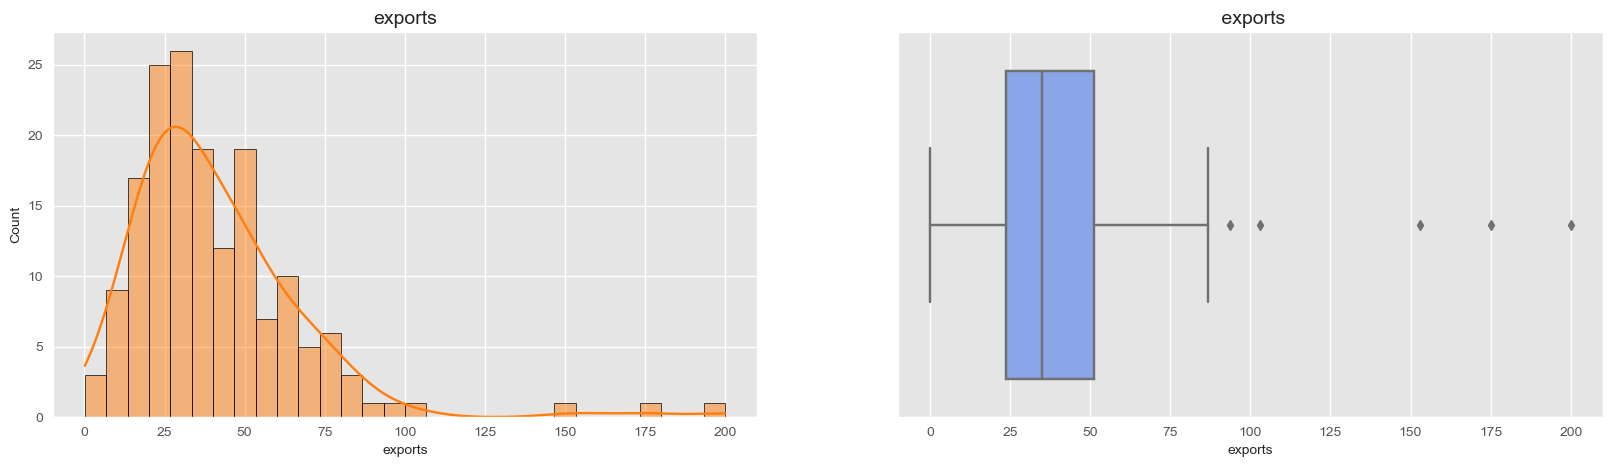

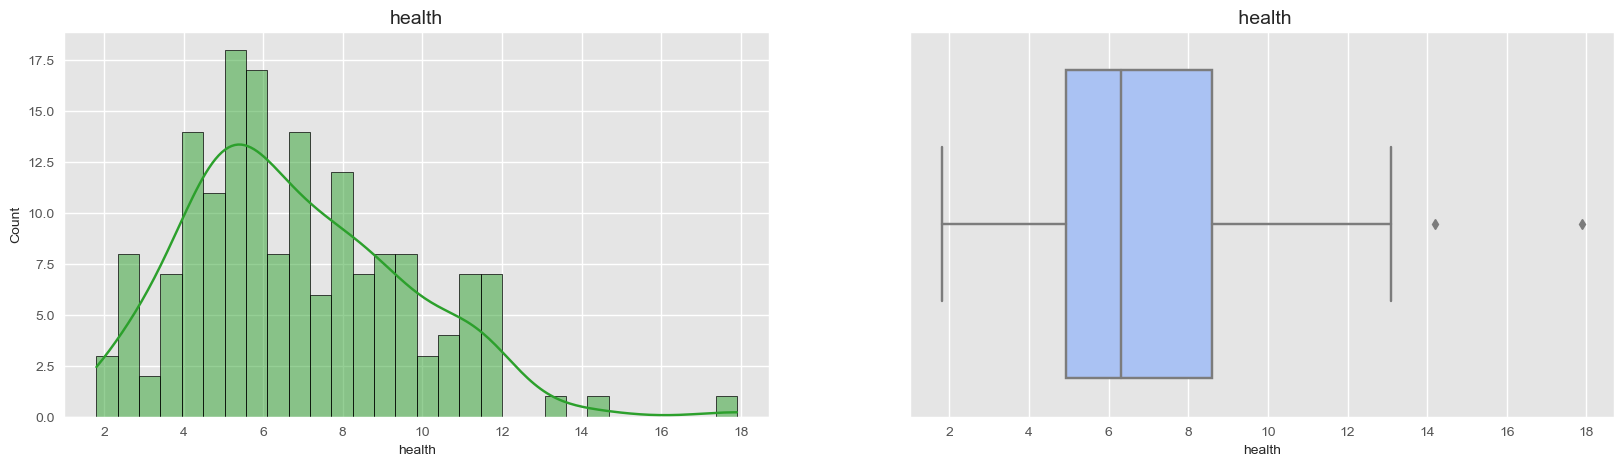

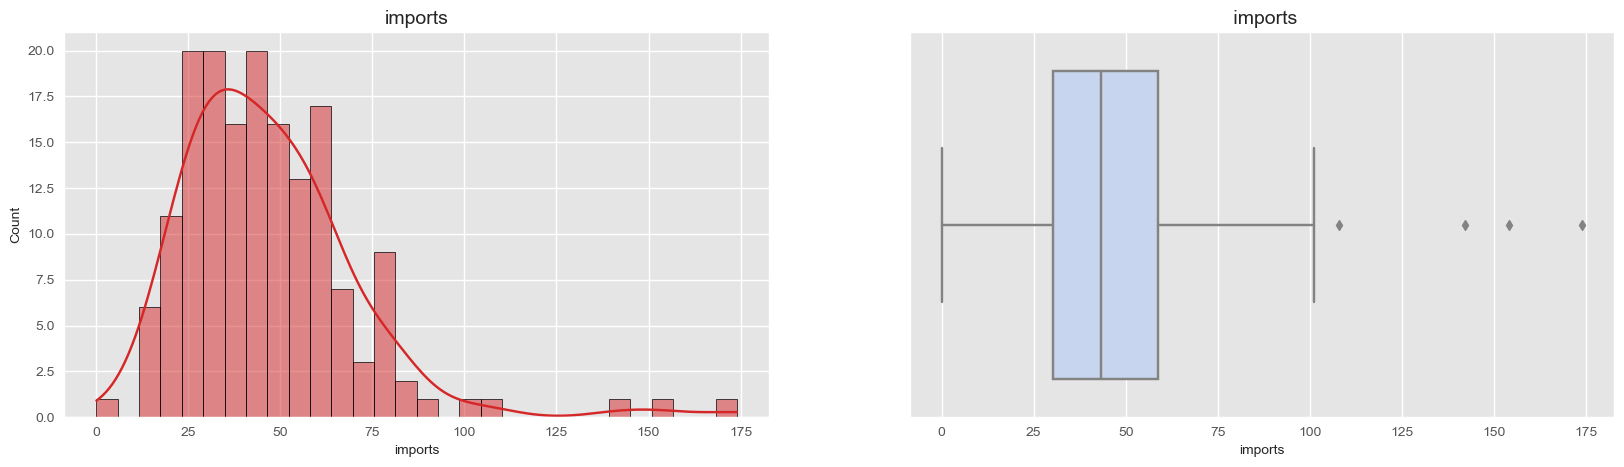

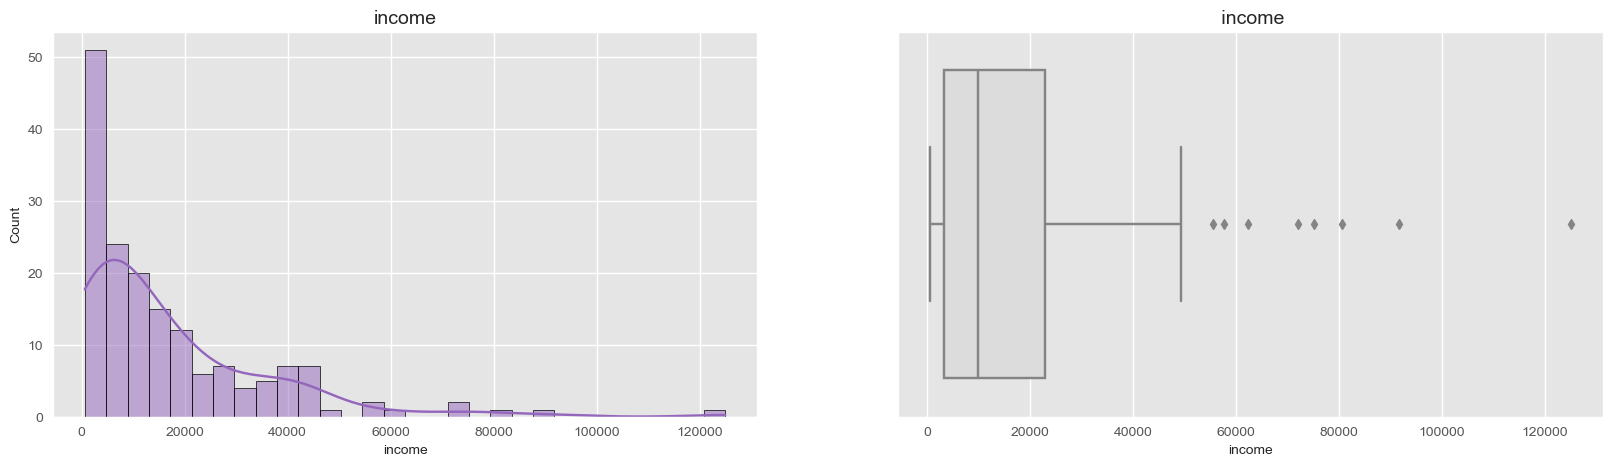

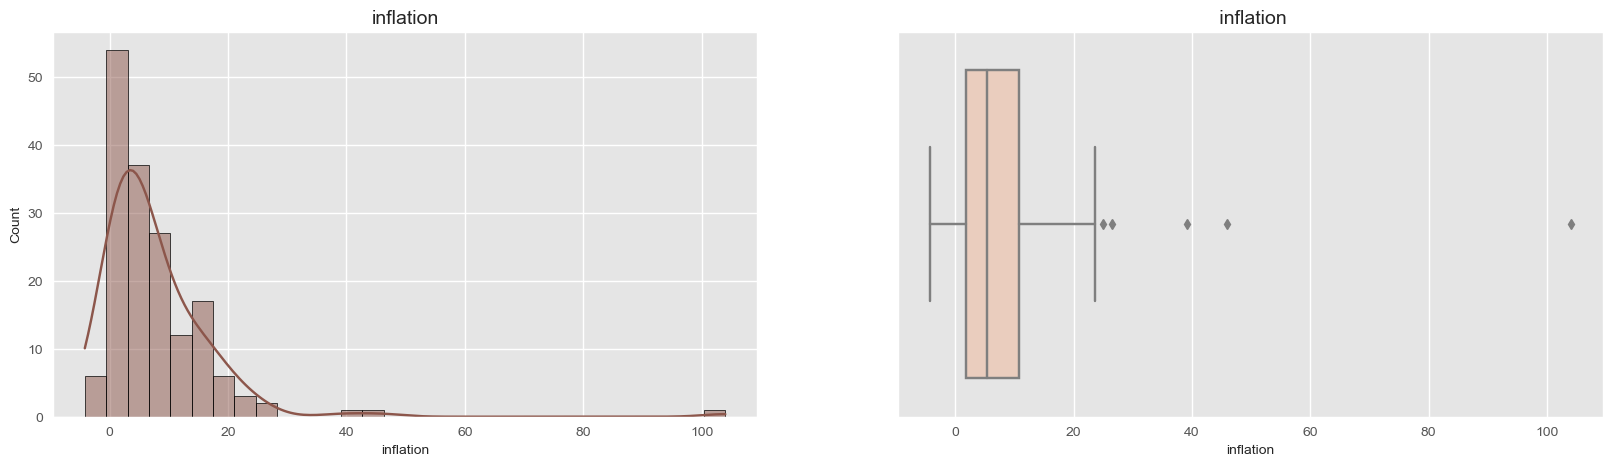

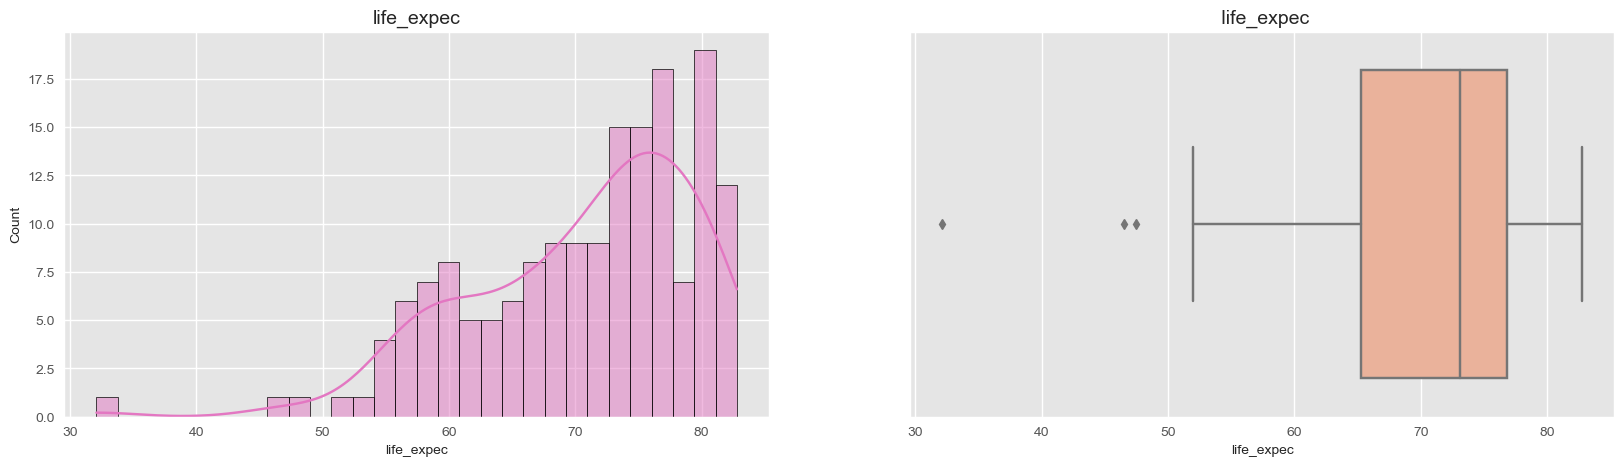

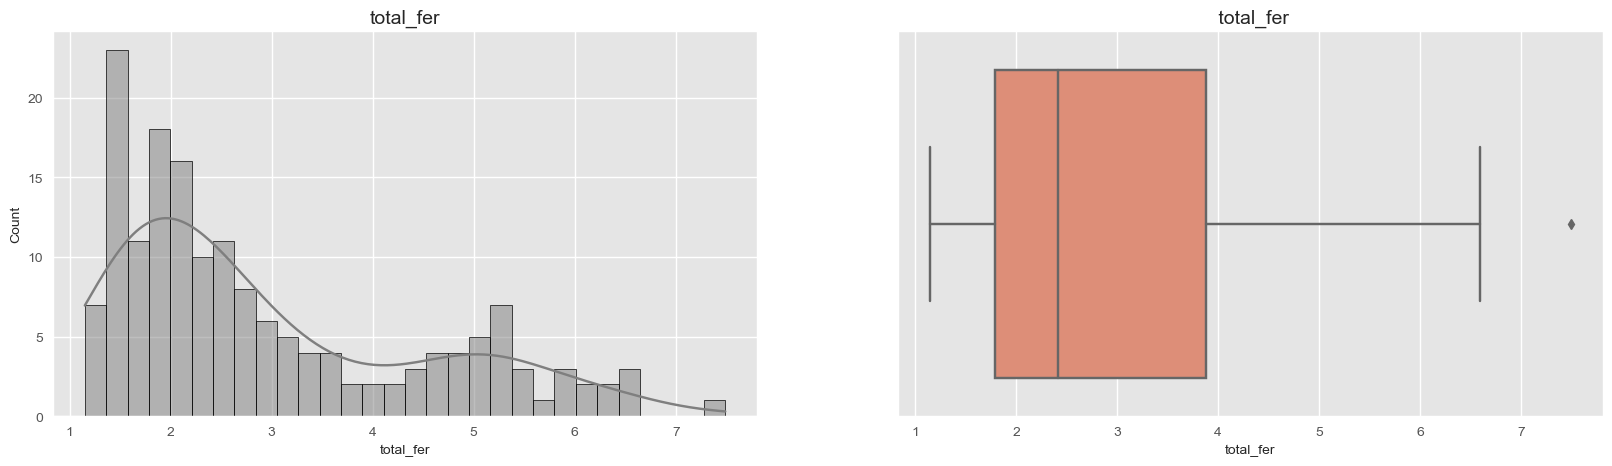

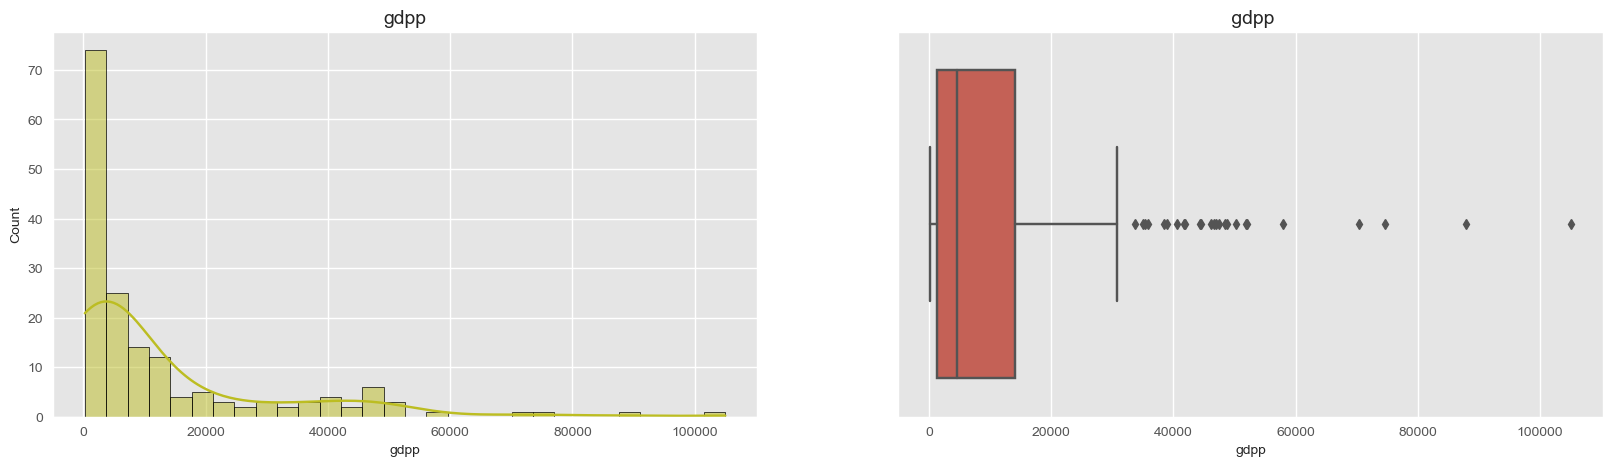

In [5]:
hist_colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']
box_palette = sns.color_palette("coolwarm", len(df.drop('country', axis=1).columns))

for index, col in enumerate(df.drop('country', axis=1).columns):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    sns.histplot(df[col],bins=30,kde=True,color=hist_colors[index % len(hist_colors)],ax=ax[0], edgecolor='black')
    ax[0].set_title(f'{col}', fontsize=14)

    sns.boxplot(x=df[col], ax=ax[1], color=box_palette[index % len(box_palette)])
    ax[1].set_title(f' {col}', fontsize=14)
    
    plt.show()

### Insights:
1. **chlid_mort: Right skewed indicating most countries have low child mortality, outliers shown in the boxplot might show certain underdeveloped countries**
2. **exports,health,imports: Similar distribution with some outliers that hint probably developed countries with a great economy**
3. **income, inflation, gdpp highly right skewed showing that most countries are in the lowest part and some have extremely high values. A high correlation is expected also for income and gdpp as shown by the graphs**






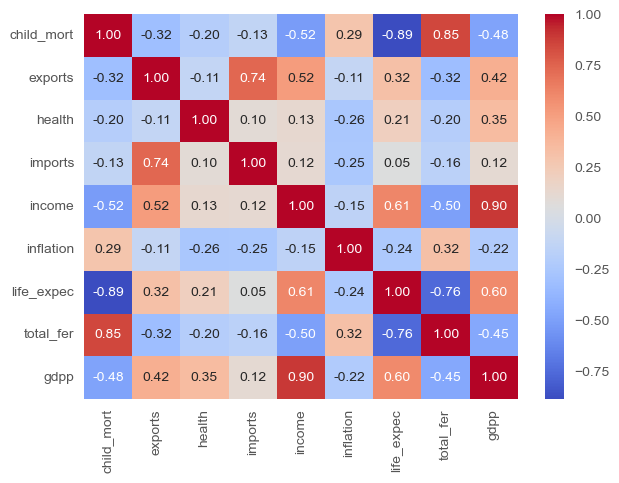

In [6]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm', fmt='.2f')
plt.show()

## Key Correlations:
1. child_mort + life_expect [0.89]: Countries with higher child mortality have lower life expectancies
2. child_mort and total_fer [0.85]: Higher child mortality leads to higher fertility rates
3. exports + imports [0.74]: Countries with more exports tend to also have more imports
4. income + gdpp [0.90]: As expected higher income leads to higher GDP per capita 

In [7]:
# Map visualization for each column
for i in df.drop('country', axis=1).columns:
    fig = px.choropleth(df,
                        locationmode='country names',
                        locations='country',
                        hover_name='country',
                         title=i+' per country (World)',color=i,
                        color_continuous_scale='RdYlGn',
                         projection='natural earth'
                       )
    #fig.write_html(f"Interactive-plots_World_{i}.html")
    fig.update_geos(fitbounds="locations", visible=True)
    fig.show()

### Check for top 5  countries per category

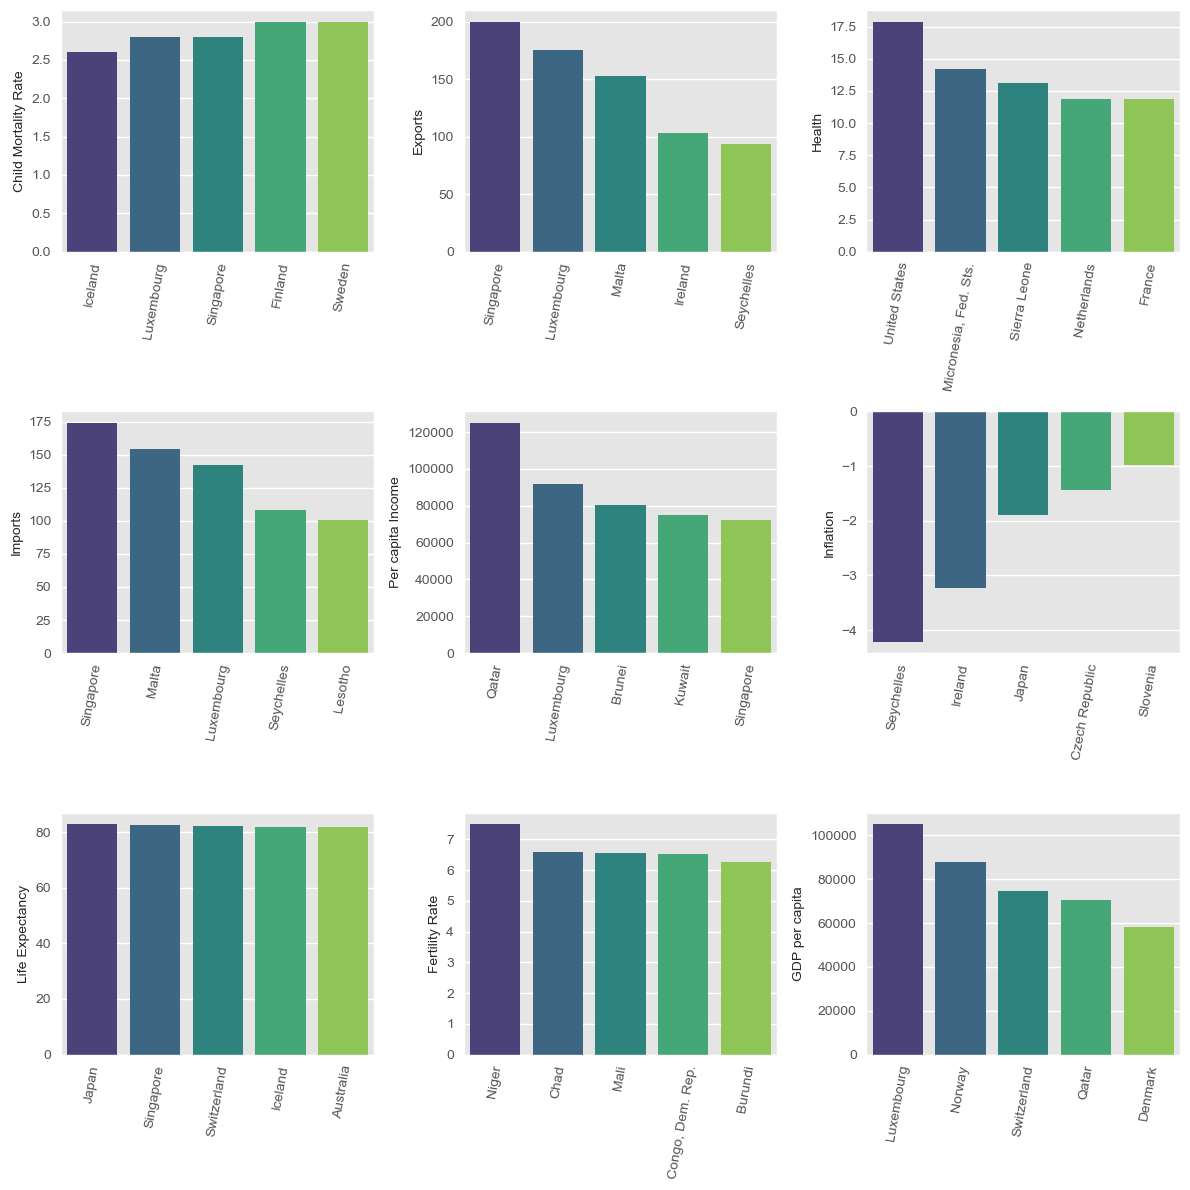

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# top 5 countries represented as `top5`

# Child Mortality Rate
top5_child_mort = df[['country', 'child_mort']].sort_values('child_mort', ascending=True).head()
plt1 = sns.barplot(x='country', y='child_mort', data=top5_child_mort, ax=axs[0, 0], palette='viridis')
plt1.set(xlabel='', ylabel='Child Mortality Rate')

# Exports
top5_exports = df[['country', 'exports']].sort_values('exports', ascending=False).head()
plt2 = sns.barplot(x='country', y='exports', data=top5_exports, ax=axs[0, 1], palette='viridis')
plt2.set(xlabel='', ylabel='Exports')

# Health
top5_health = df[['country', 'health']].sort_values('health', ascending=False).head()
plt3 = sns.barplot(x='country', y='health', data=top5_health, ax=axs[0, 2], palette='viridis')
plt3.set(xlabel='', ylabel='Health')

# Imports
top5_imports = df[['country', 'imports']].sort_values('imports', ascending=False).head()
plt4 = sns.barplot(x='country', y='imports', data=top5_imports, ax=axs[1, 0], palette='viridis')
plt4.set(xlabel='', ylabel='Imports')

# Per capita Income
top5_income = df[['country', 'income']].sort_values('income', ascending=False).head()
plt5 = sns.barplot(x='country', y='income', data=top5_income, ax=axs[1, 1], palette='viridis')
plt5.set(xlabel='', ylabel='Per capita Income')

# Inflation
top5_inflation = df[['country', 'inflation']].sort_values('inflation', ascending=True).head()
plt6 = sns.barplot(x='country', y='inflation', data=top5_inflation, ax=axs[1, 2], palette='viridis')
plt6.set(xlabel='', ylabel='Inflation')

# Life Expectancy
top5_life_expec = df[['country', 'life_expec']].sort_values('life_expec', ascending=False).head()
plt8 = sns.barplot(x='country', y='life_expec', data=top5_life_expec, ax=axs[2, 0], palette='viridis')
plt8.set(xlabel='', ylabel='Life Expectancy')

# Fertility Rate
top5_total_fer = df[['country', 'total_fer']].sort_values('total_fer', ascending=False).head()
plt7 = sns.barplot(x='country', y='total_fer', data=top5_total_fer, ax=axs[2, 1], palette='viridis')
plt7.set(xlabel='', ylabel='Fertility Rate')

# The GDP per capita
top5_gdpp = df[['country', 'gdpp']].sort_values('gdpp', ascending=False).head()
plt9 = sns.barplot(x='country', y='gdpp', data=top5_gdpp, ax=axs[2, 2], palette='viridis')
plt9.set(xlabel='', ylabel='GDP per capita')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=80)

plt.tight_layout()
plt.show()

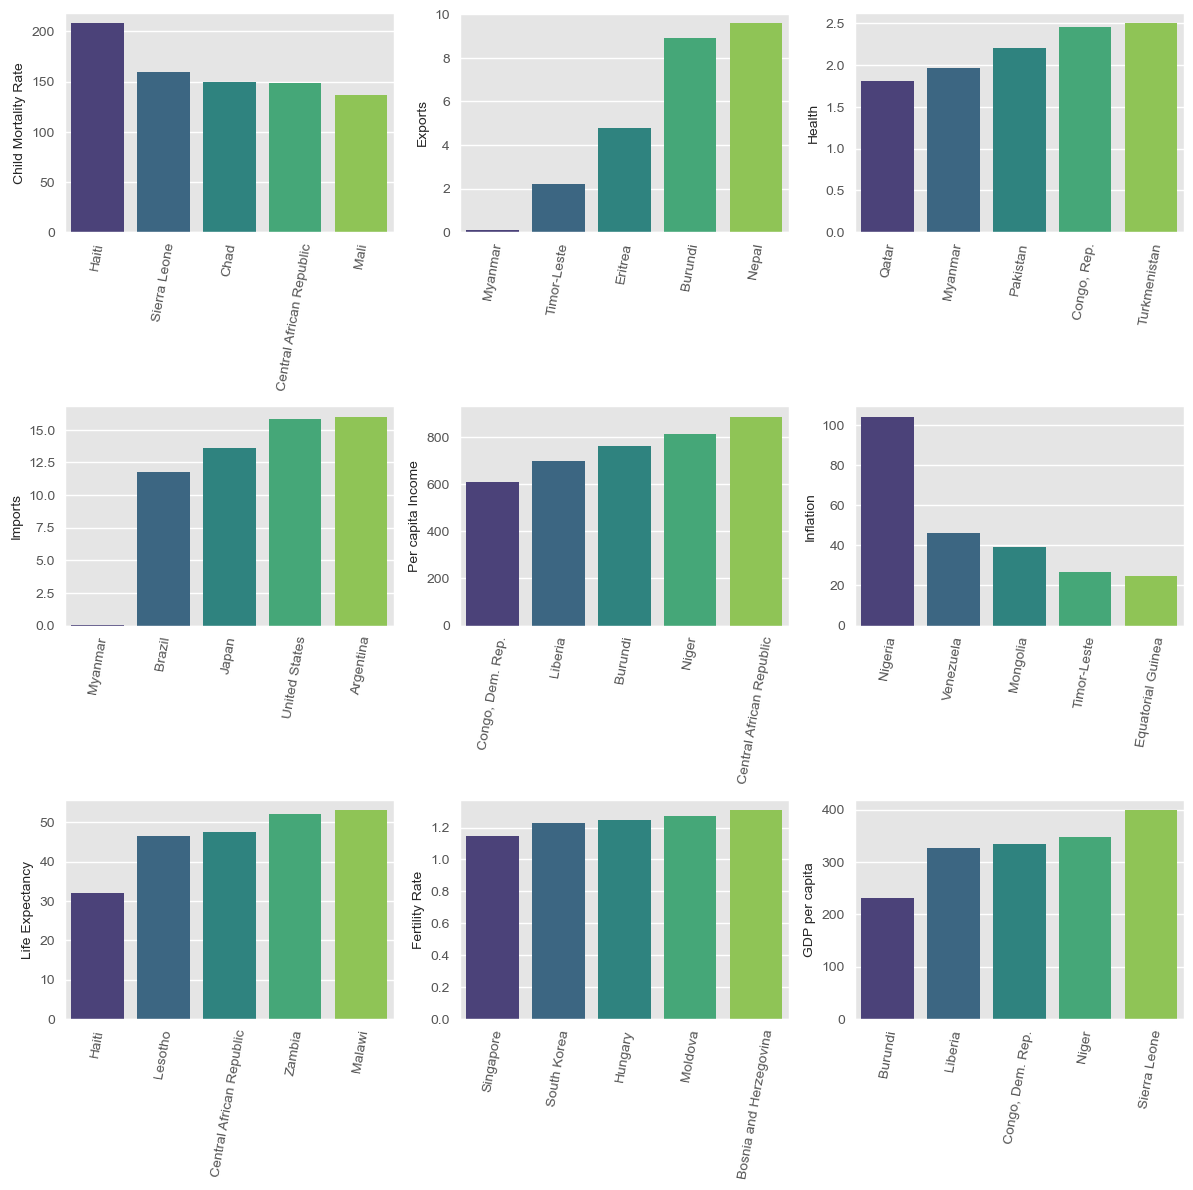

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# bottom 5 countries per category represented as `top5`

# Child Mortality Rate
top5_child_mort = df[['country', 'child_mort']].sort_values('child_mort', ascending=False).head()
plt1 = sns.barplot(x='country', y='child_mort', data=top5_child_mort, ax=axs[0, 0], palette='viridis')
plt1.set(xlabel='', ylabel='Child Mortality Rate')

# Exports
top5_exports = df[['country', 'exports']].sort_values('exports', ascending=True).head()
plt2 = sns.barplot(x='country', y='exports', data=top5_exports, ax=axs[0, 1], palette='viridis')
plt2.set(xlabel='', ylabel='Exports')

# Health
top5_health = df[['country', 'health']].sort_values('health', ascending=True).head()
plt3 = sns.barplot(x='country', y='health', data=top5_health, ax=axs[0, 2], palette='viridis')
plt3.set(xlabel='', ylabel='Health')

# Imports
top5_imports = df[['country', 'imports']].sort_values('imports', ascending=True).head()
plt4 = sns.barplot(x='country', y='imports', data=top5_imports, ax=axs[1, 0], palette='viridis')
plt4.set(xlabel='', ylabel='Imports')

# Per capita Income
top5_income = df[['country', 'income']].sort_values('income', ascending=True).head()
plt5 = sns.barplot(x='country', y='income', data=top5_income, ax=axs[1, 1], palette='viridis')
plt5.set(xlabel='', ylabel='Per capita Income')

# Inflation
top5_inflation = df[['country', 'inflation']].sort_values('inflation', ascending=False).head()
plt6 = sns.barplot(x='country', y='inflation', data=top5_inflation, ax=axs[1, 2], palette='viridis')
plt6.set(xlabel='', ylabel='Inflation')

# Fertility Rate
top5_total_fer = df[['country', 'total_fer']].sort_values('total_fer', ascending=True).head()
plt7 = sns.barplot(x='country', y='total_fer', data=top5_total_fer, ax=axs[2, 1], palette='viridis')
plt7.set(xlabel='', ylabel='Fertility Rate')

# Life Expectancy
top5_life_expec = df[['country', 'life_expec']].sort_values('life_expec', ascending=True).head()
plt8 = sns.barplot(x='country', y='life_expec', data=top5_life_expec, ax=axs[2, 0], palette='viridis')
plt8.set(xlabel='', ylabel='Life Expectancy')

# The GDP per capita
top5_gdpp = df[['country', 'gdpp']].sort_values('gdpp', ascending=True).head()
plt9 = sns.barplot(x='country', y='gdpp', data=top5_gdpp, ax=axs[2, 2], palette='viridis')
plt9.set(xlabel='', ylabel='GDP per capita')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=80)

plt.tight_layout()
plt.show()

## Handle Outliers

- Use of IQR Method to identify outliers in each column

In [10]:
def iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [11]:
#numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Identify outliers for each column
outliers_dict = {}
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    outliers = iqr_outliers(df, col)
    outliers_dict[col] = outliers['country'].tolist()

outliers_dict

{'child_mort': ['Central African Republic', 'Chad', 'Haiti', 'Sierra Leone'],
 'exports': ['Ireland', 'Luxembourg', 'Malta', 'Seychelles', 'Singapore'],
 'health': ['Micronesia, Fed. Sts.', 'United States'],
 'imports': ['Luxembourg', 'Malta', 'Seychelles', 'Singapore'],
 'income': ['Brunei',
  'Kuwait',
  'Luxembourg',
  'Norway',
  'Qatar',
  'Singapore',
  'Switzerland',
  'United Arab Emirates'],
 'inflation': ['Equatorial Guinea',
  'Mongolia',
  'Nigeria',
  'Timor-Leste',
  'Venezuela'],
 'life_expec': ['Central African Republic', 'Haiti', 'Lesotho'],
 'total_fer': ['Niger'],
 'gdpp': ['Australia',
  'Austria',
  'Belgium',
  'Brunei',
  'Canada',
  'Denmark',
  'Finland',
  'France',
  'Germany',
  'Iceland',
  'Ireland',
  'Italy',
  'Japan',
  'Kuwait',
  'Luxembourg',
  'Netherlands',
  'New Zealand',
  'Norway',
  'Qatar',
  'Singapore',
  'Sweden',
  'Switzerland',
  'United Arab Emirates',
  'United Kingdom',
  'United States']}

### These outliers represent unique cases of the data so they won't be removed

### Transform variables using logarithmic function

In [12]:
df_transformed = df.copy()
df_transformed[df.select_dtypes(
    include=['float64', 'int64']).columns] = df[df.select_dtypes(
        include=['float64', 'int64']).columns].apply(lambda x: np.log(x + 1))

df_transformed.head()

country  child_mort   exports    health   imports    income  \
0          Afghanistan    4.513055  2.397895  2.149434  3.826465  7.384610   
1              Albania    2.867899  3.367296  2.021548  3.903991  9.203416   
2              Algeria    3.342862  3.673766  1.642873  3.478158  9.465060   
3               Angola    4.787492  4.147885  1.348073  3.781914  8.682877   
4  Antigua and Barbuda    2.424803  3.839452  1.950187  4.092677  9.857496   

   inflation  life_expec  total_fer      gdpp  
0   2.345645    4.046554   1.919859  6.317165  
1   1.702928    4.347694   0.974560  8.316545  
2   2.839078    4.350278   1.358409  8.403128  
3   3.152736    4.112512   1.968510  8.169336  
4   0.891998    4.354141   1.141033  9.409273

In [13]:
df_transformed.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     4
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [14]:
df_transformed[df_transformed['inflation'].isnull()]['country']

43     Czech Republic
73            Ireland
77              Japan
131        Seychelles
Name: country, dtype: object

In [15]:
df[['country', 'inflation']].sort_values('inflation', ascending=True).head(10)

country  inflation
131      Seychelles     -4.210
73          Ireland     -3.220
77            Japan     -1.900
43   Czech Republic     -1.430
135        Slovenia     -0.987
85           Latvia     -0.812
10          Bahamas     -0.393
133       Singapore     -0.046
139           Spain      0.160
86          Lebanon      0.238

In [16]:
df_transformed[['country', 'inflation']].sort_values('inflation', ascending=True).head(5)

country  inflation
135   Slovenia  -4.342806
85      Latvia  -1.671313
10     Bahamas  -0.499226
133  Singapore  -0.047092
139      Spain   0.148420

## Since Log transformation can't take the negative values that are in the inflation rate column, rework the column using Linear Regression

- Using certain values we will fit a linear model to predict the missing values that have a negative value
- These Countries are: Czech Republic, Ireland, Japan and Seychelles

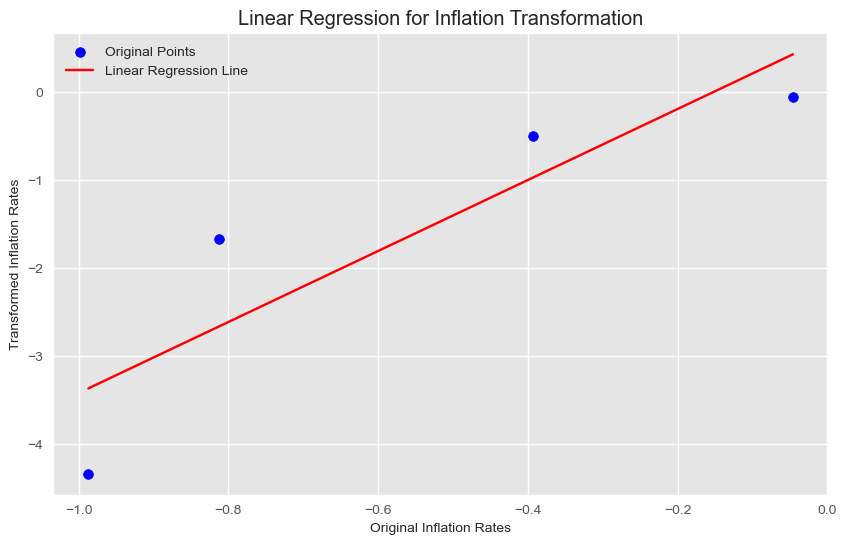

In [17]:
from sklearn.linear_model import LinearRegression
# Define the original and transformed inflation rates
x_original = np.array([-0.987, -0.812, -0.393, -0.046]).reshape(-1, 1)
y_transformed = np.array([-4.342807, -1.671313, -0.499226, -0.047092]).reshape(-1, 1)

linear_model = LinearRegression()

linear_model.fit(x_original, y_transformed)

x_values = np.linspace(min(x_original), max(x_original), 100).reshape(-1, 1)
y_values = linear_model.predict(x_values)

# Plot the original points and the linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_original, y_transformed, color='blue', label='Original Points')
plt.plot(x_values, y_values, color='red', label='Linear Regression Line')
plt.xlabel('Original Inflation Rates')
plt.ylabel('Transformed Inflation Rates')
plt.title('Linear Regression for Inflation Transformation')
plt.legend()
plt.show()

### Find the new values for the NaN values

In [18]:
# Define the original inflation rates for the countries with NaN values
x_nan_countries = np.array([-4.21, -3.22, -1.9, -1.43]).reshape(-1, 1)

y_predicted = linear_model.predict(x_nan_countries)

# Display the predicted transformed inflation rates
y_predicted.flatten()

array([-16.37502486, -12.37897878,  -7.05091734,  -5.15380456])

In [19]:
nan_countries_list=df_transformed[df_transformed['inflation'].isnull()]['country'].tolist()
predicted_values_dict = dict(zip(nan_countries_list, y_predicted.flatten()))

# Update the transformed and scaled dataset with these predicted values
for country, value in predicted_values_dict.items():
    df_transformed.loc[df_transformed['country'] == country, 'inflation'] = value

In [20]:
df_transformed.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Data Scaling

### We will proceed with the dataset before the transformation as it provided better clustering
 Feel free to try both ways though

- With transformation

In [21]:
#X_prescaled = df_transformed.drop(columns=['country'])

- Without transformation

In [22]:
X_prescaled = df.drop(columns=['country'])

In [23]:
scaler = StandardScaler()

'''fit scaler on numeric features'''
scaler.fit(X_prescaled)

'''scale numeric features now'''
X = scaler.transform(X_prescaled)

## Elbow Method to identify best split

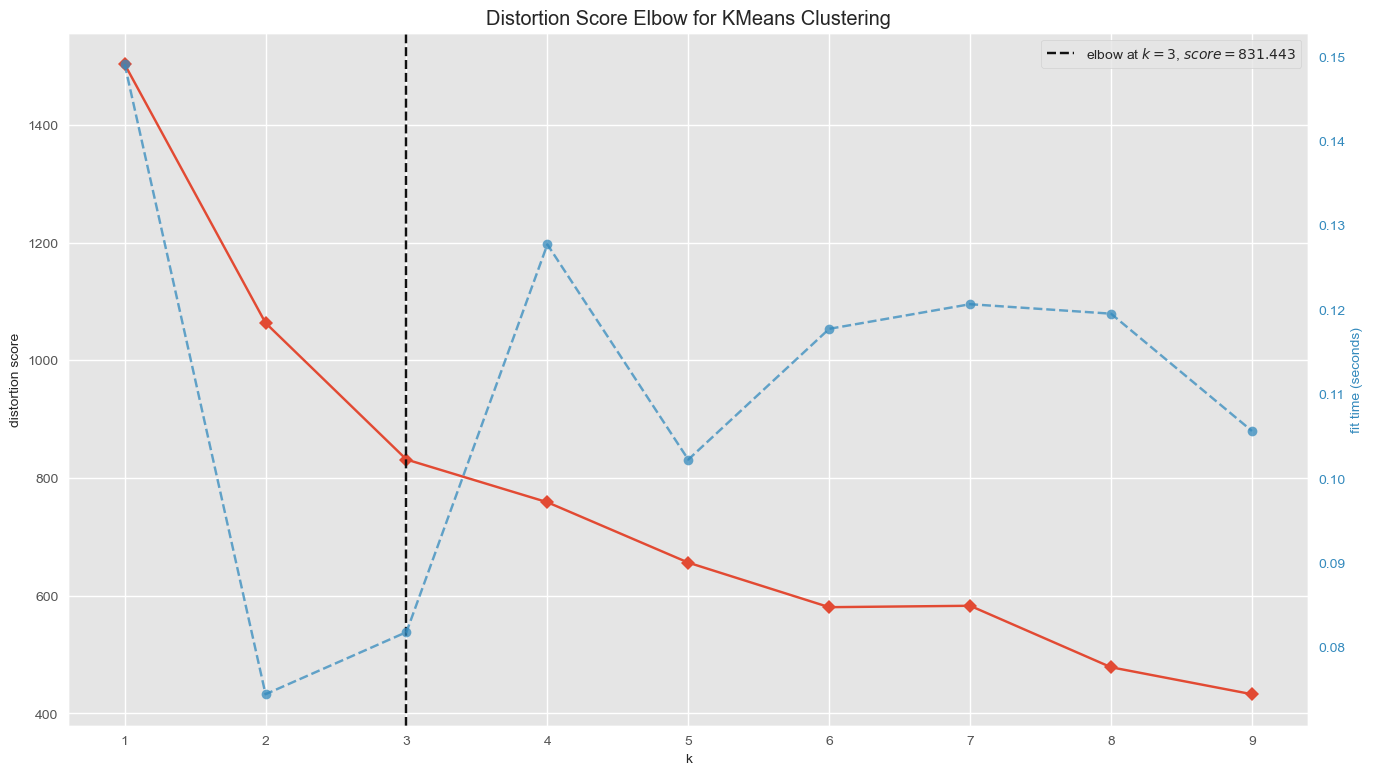

In [24]:
# Instantiate the clustering model and visualizer
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(1,10), locate_elbow=True)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.poof()        # Draw/show/poof the data
plt.show()

## Silhouette Method to identify best split

----------------------------------------------------------------------
For n_clusters = 2 The average silhouette_score is : 0.28735668921406704


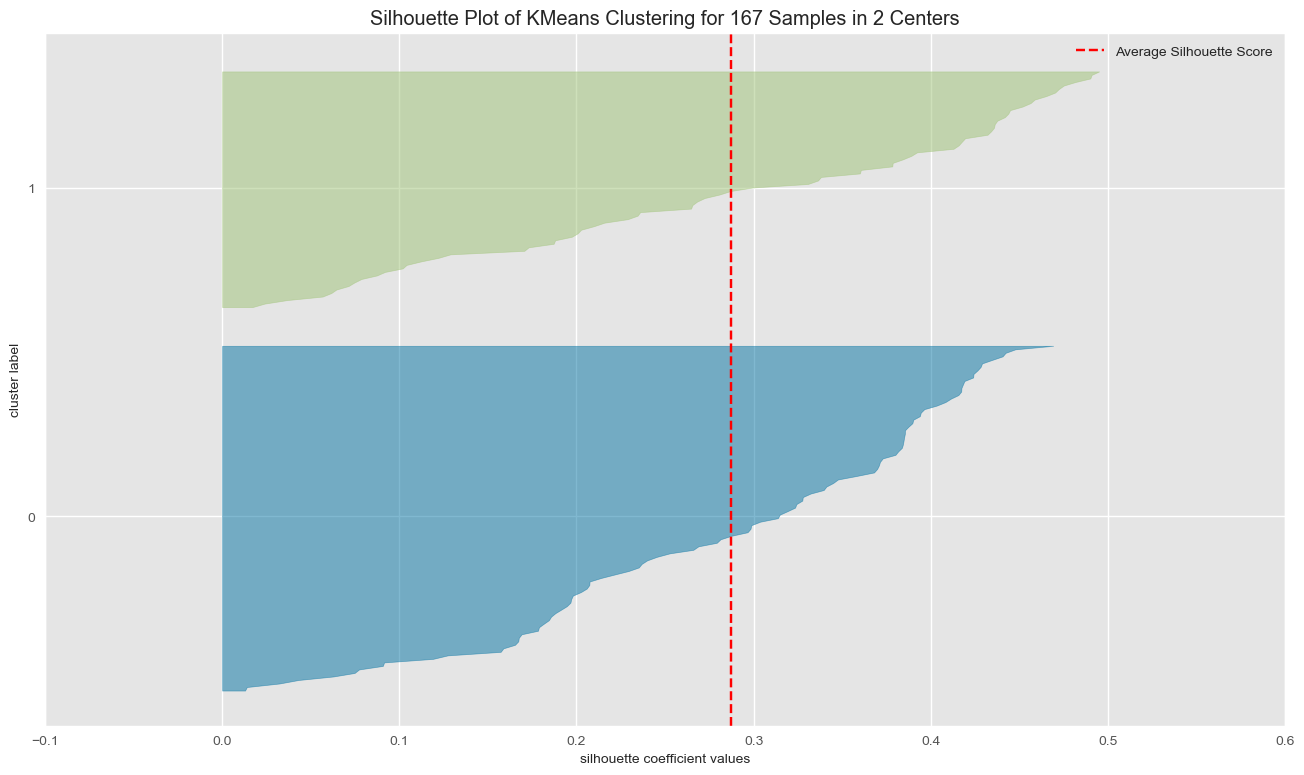

----------------------------------------------------------------------
For n_clusters = 3 The average silhouette_score is : 0.28329575683463126


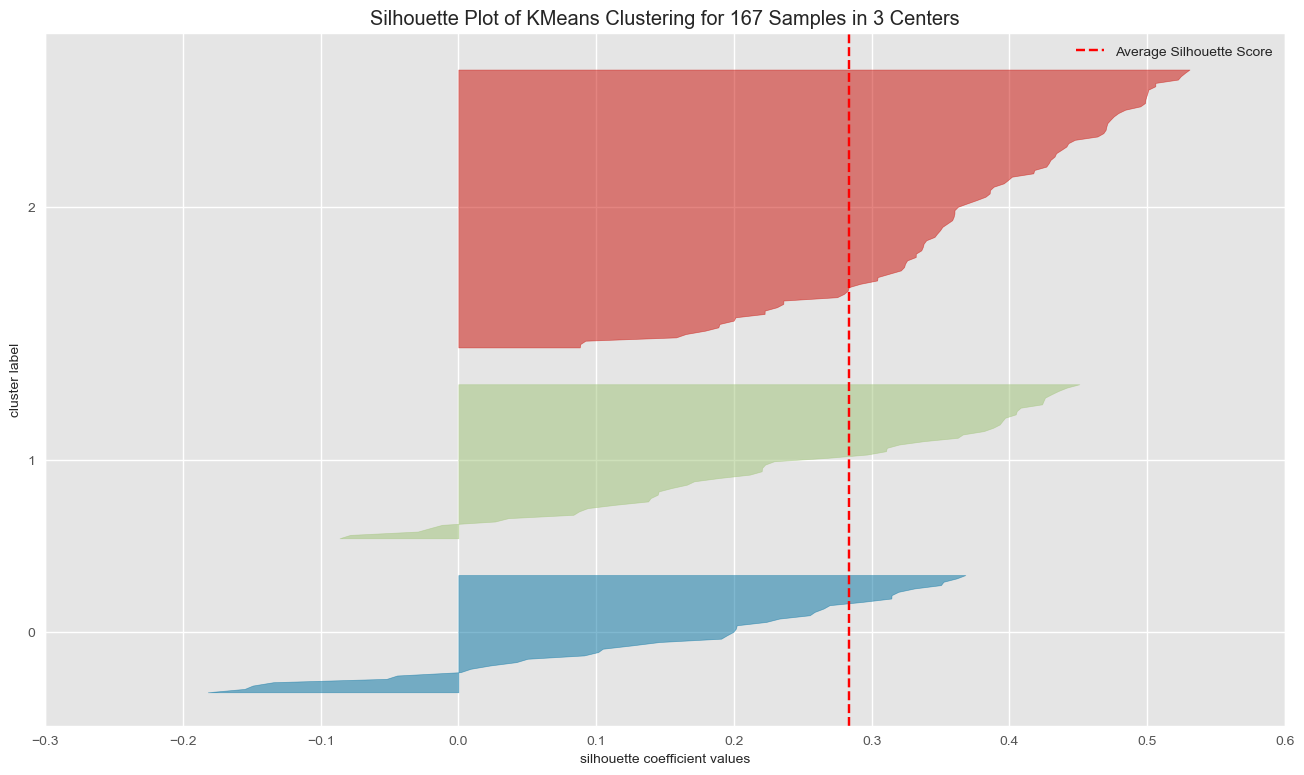

----------------------------------------------------------------------
For n_clusters = 4 The average silhouette_score is : 0.301375962376881


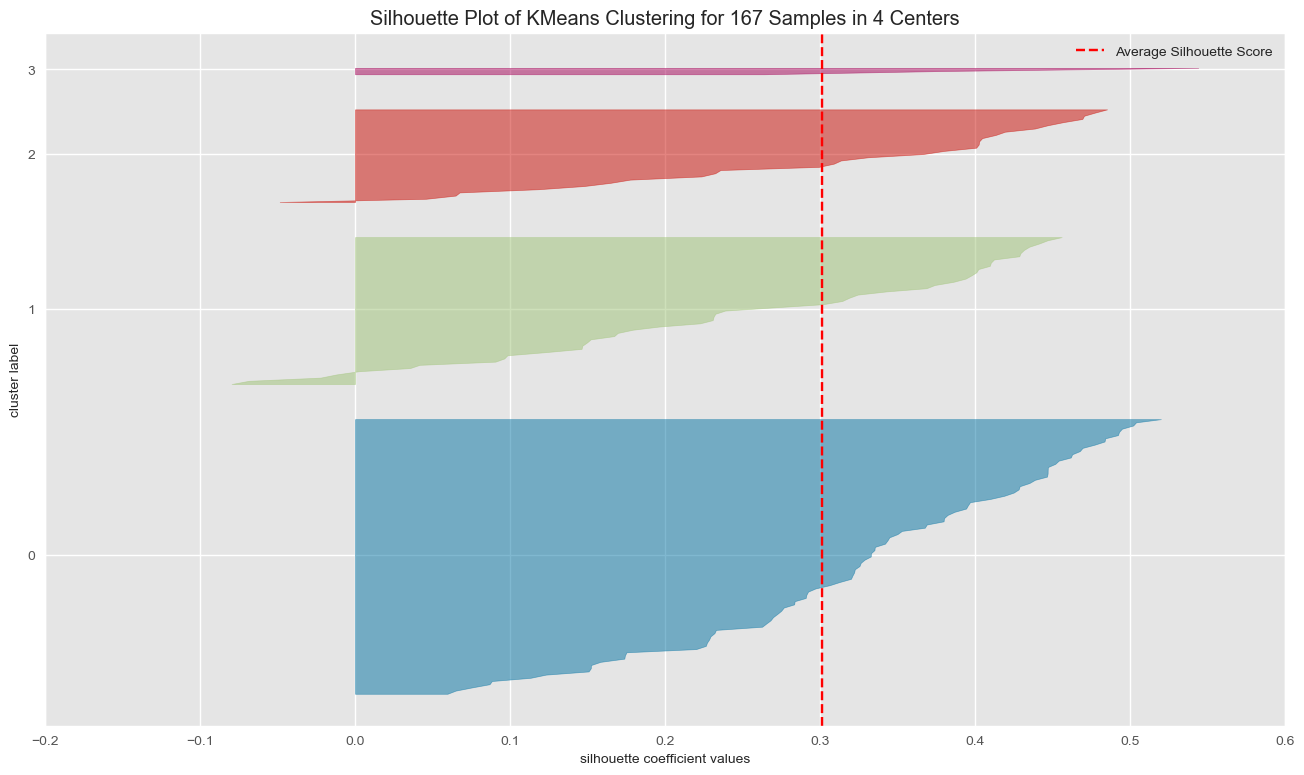

----------------------------------------------------------------------
For n_clusters = 5 The average silhouette_score is : 0.2992594995920442


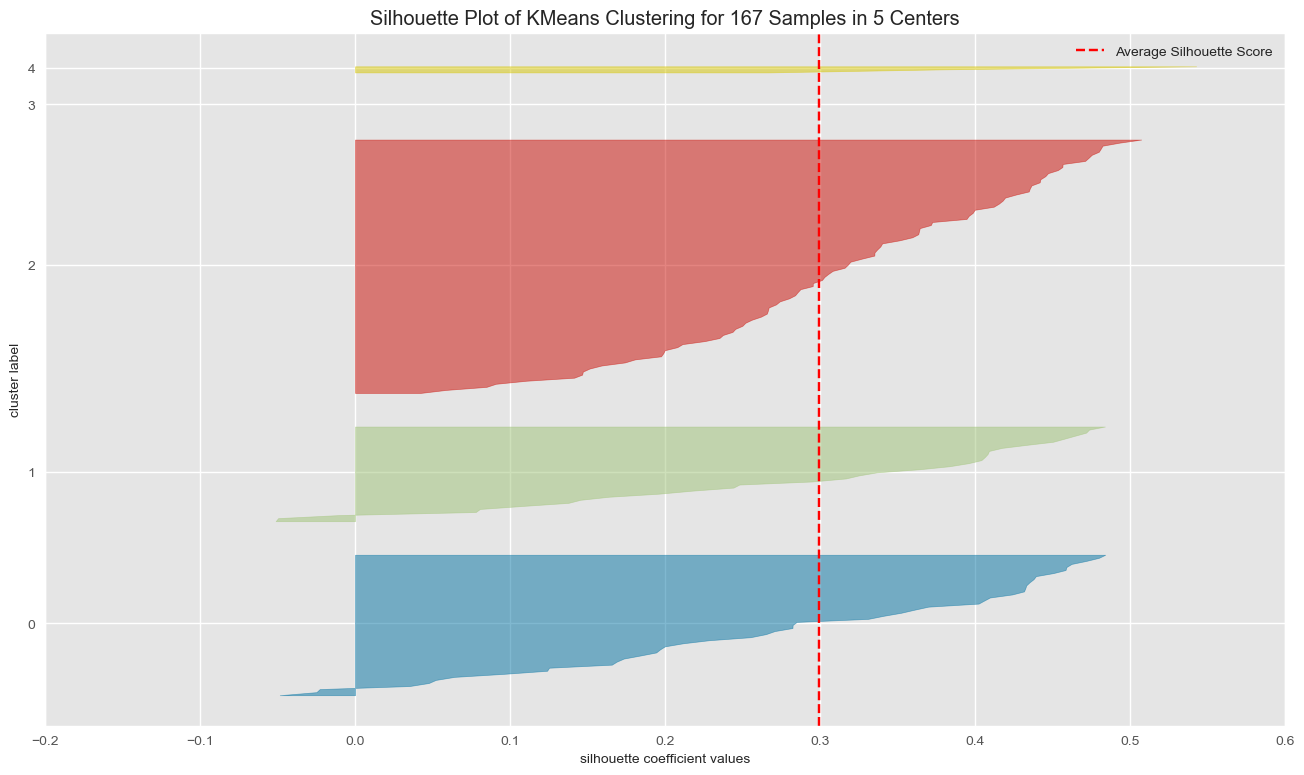

----------------------------------------------------------------------
For n_clusters = 6 The average silhouette_score is : 0.2350698927516289


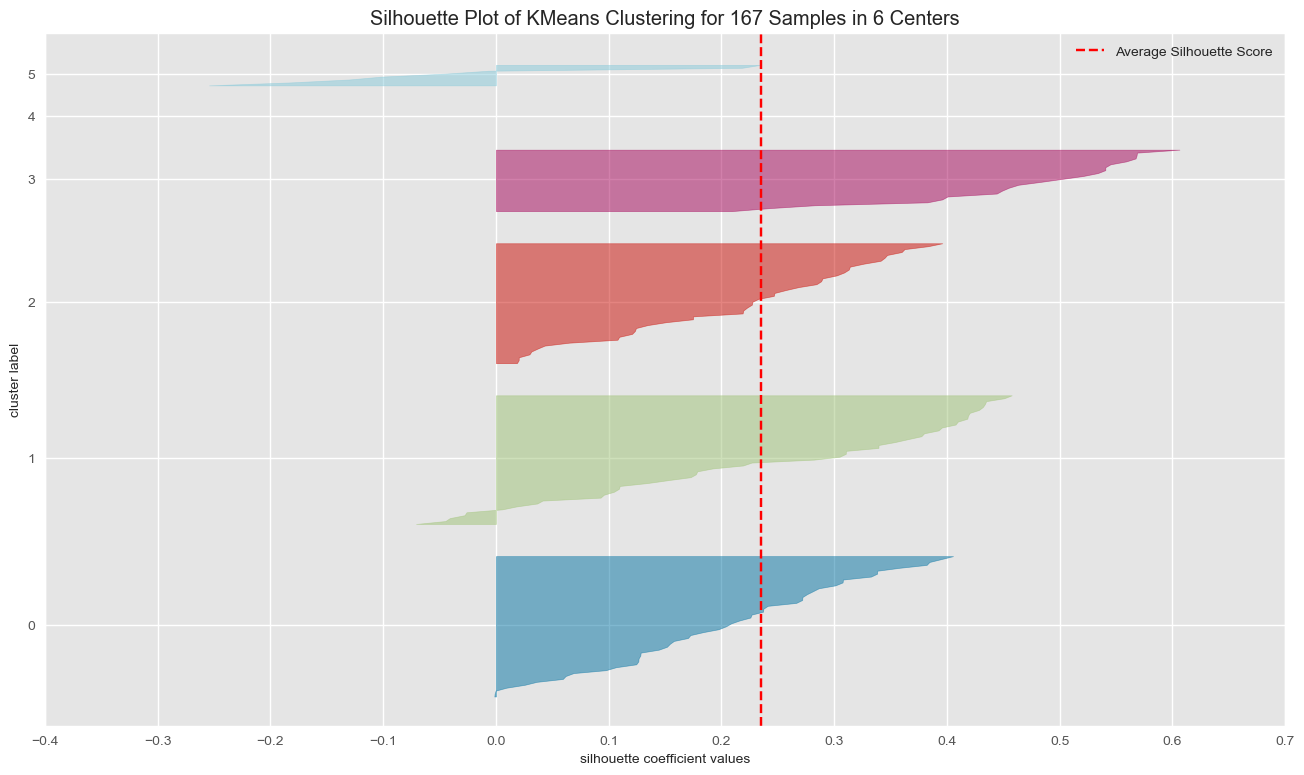

----------------------------------------------------------------------
For n_clusters = 7 The average silhouette_score is : 0.24905003461730515


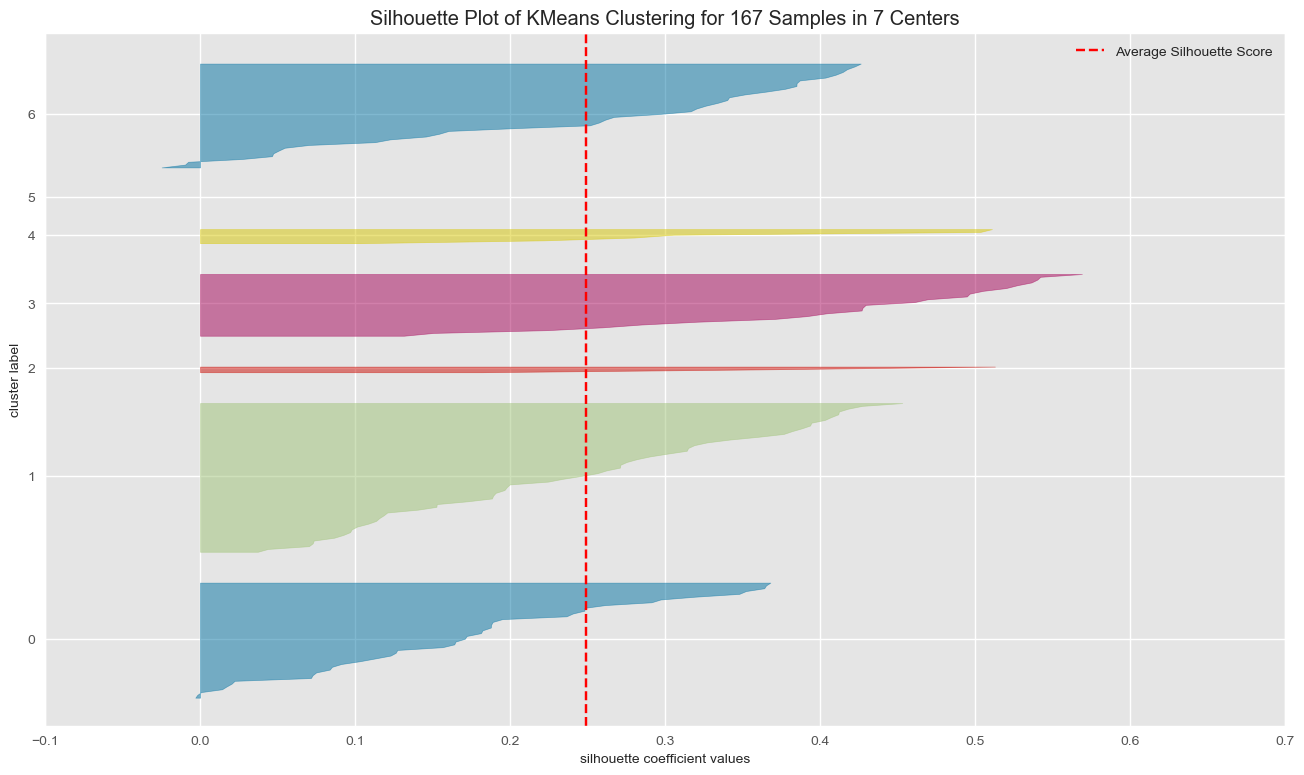

In [25]:
search_name = 'kmeans'

n_clusters = np.arange(2,8,1).tolist()

for n_clusters in n_clusters:
    
    print('-'*70)
    
    model = KMeans()

    param_dict = {'n_clusters': n_clusters,
                  'n_init': 10,
                  'random_state':42,
                 'algorithm':'auto'
                 }

    model.set_params(**param_dict)
    labels = model.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.poof()

## Following the methods above, we conclude that the best fit is for k=3 clusters, so we proceed

In [26]:
model = KMeans(
        n_clusters=3,
        init='k-means++',
#         n_jobs=-1,
        random_state=1)

model.fit(X)

df_kmeans=df.copy()
df_kmeans["clusters"]=model.labels_
df_kmeans

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  clusters  
0         9.44        56.2       5.82    553         0  
1         4.49        76.3       1.65   4090         1  
2        16.10        76.5       2.89   4460         1  
3        22.40        60.1       6.16   3530         0  
4         1.44        76.8       2.13  12200         1  
..         ...         ...        ...    ...       ...  
162       2.62        63.0       3.50   2970         1  
163      45.90        75.4       2.47  13500         1  
164      12.10        73.1       1.95   1310         1  
165      23.60        67.5       4.67   1310         0  
166      14.00        52.0       5.40   1460         0  

[167 rows x 11 columns]

In [27]:
mean_values=df_kmeans.groupby("clusters").mean()
mean_values

child_mort    exports    health    imports        income  inflation  \
clusters                                                                        
0          92.961702  29.151277  6.388511  42.323404   3942.404255  12.019681   
1          21.927381  40.243917  6.200952  47.473404  12305.595238   7.600905   
2           5.000000  58.738889  8.807778  51.491667  45672.222222   2.671250   

          life_expec  total_fer          gdpp  
clusters                                       
0          59.187234   5.008085   1922.382979  
1          72.814286   2.307500   6486.452381  
2          80.127778   1.752778  42494.444444

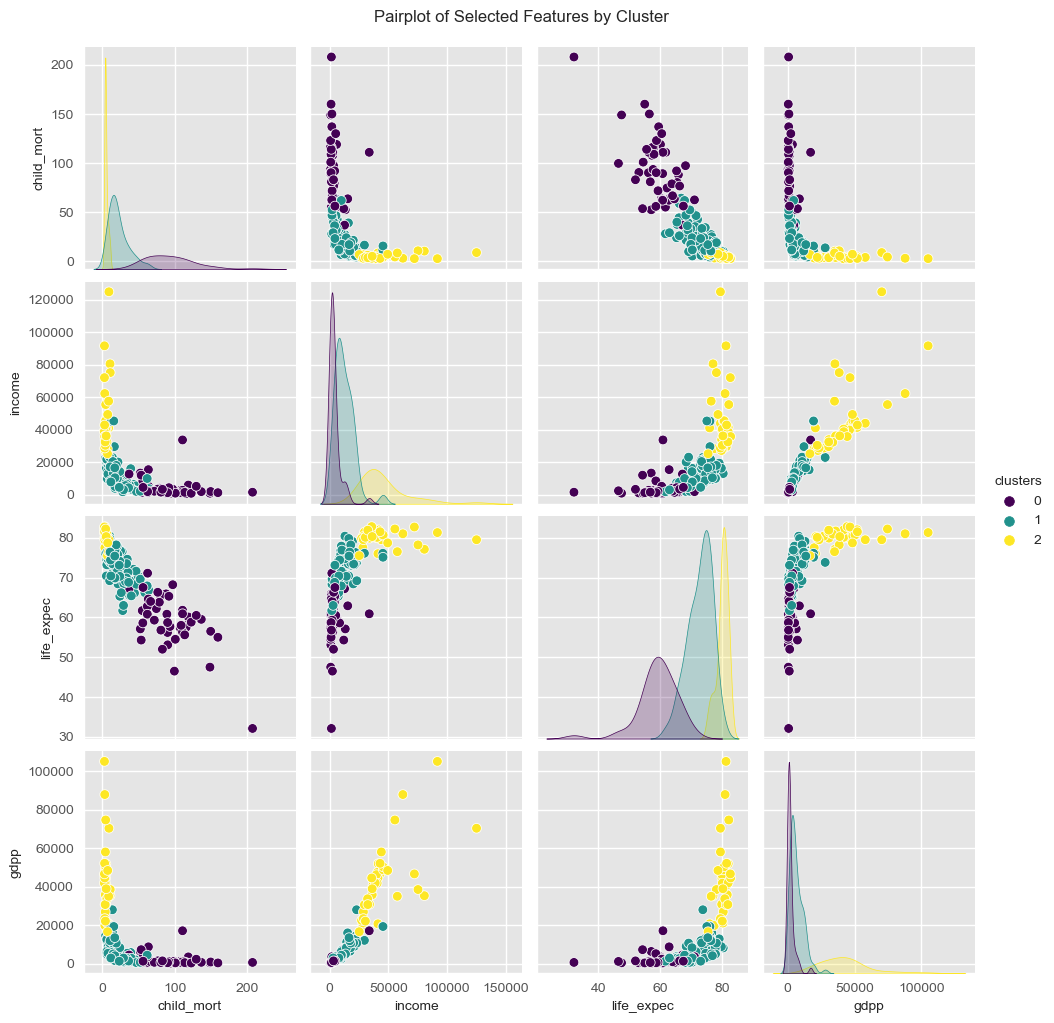

In [28]:
selected_features = ['child_mort', 'income', 'life_expec', 'gdpp']
sns.pairplot(data=df_kmeans, hue='clusters', vars=selected_features, palette='viridis')
plt.suptitle('Pairplot of Selected Features by Cluster', y=1.02)
plt.show()

In [29]:
df_kmeans['clusters'].loc[df_kmeans['clusters'] == 0] = 'Under-developed countries'
df_kmeans['clusters'].loc[df_kmeans['clusters'] == 1] = 'Developing countries'
df_kmeans['clusters'].loc[df_kmeans['clusters'] == 2] = 'Developed countries'

In [30]:
fig = px.choropleth(df_kmeans[['country','clusters']],
                    locationmode = 'country names',
                    locations = 'country',
                    title = 'Rate of Development Per Country (kMeans)',
                    color = df_kmeans['clusters'], 
                    color_discrete_map = {'Under-developed countries':'Red',
                                        'Developed countries':'Green',
                                        'Developing countries':'Yellow'},
                    projection='natural earth'
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

## Hierarchical Clustering using sklearn agglomerative()

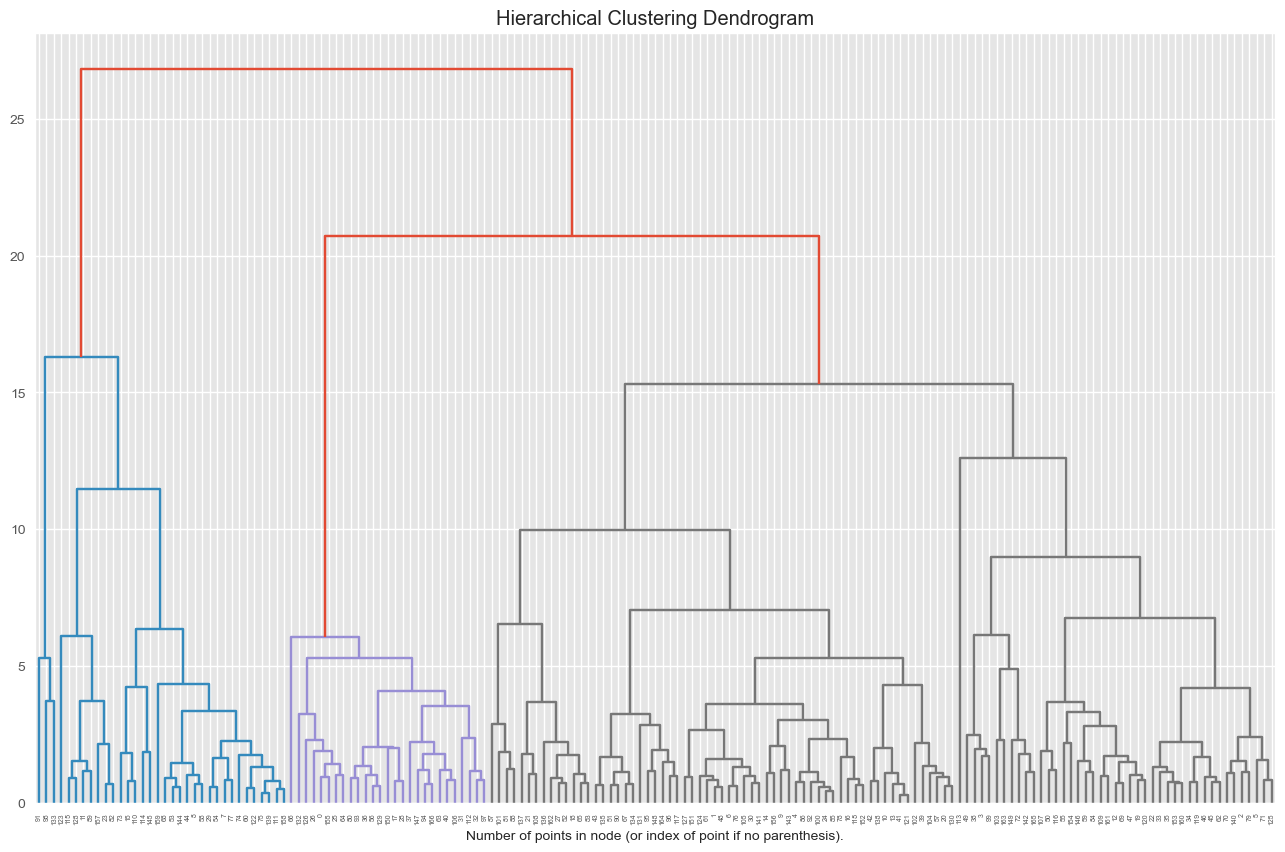

In [31]:
# Create Dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

model = model.fit(X)
plt.figure(figsize=(16,10))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=100)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

**Let's explore agglomerative for 3 clusters!**

In [32]:
cluster1 = AgglomerativeClustering(n_clusters=3, linkage='ward')  
cluster1.fit_predict(X)

#df_hier=df_transformed.copy()
df_hier=df.copy()
df_hier["clusters"]=cluster1.labels_
df_hier

country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  clusters  
0         9.44        56.2       5.82    553         2  
1         4.49        76.3       1.65   4090         1  
2        16.10        76.5       2.89   4460         1  
3        22.40        60.1       6.16   3530         1  
4         1.44        76.8       2.13  12200         1  
..         ...         ...        ...    ...       ...  
162       2.62        63.0       3.50   2970         1  
163      45.90        75.4       2.47  13500         1  
164      12.10        73.1       1.95   1310         1  
165      23.60        67.5       4.67   1310         1  
166      14.00        52.0       5.40   1460         2  

[167 rows x 11 columns]

In [33]:
mean_values1=df_hier.groupby("clusters").mean()
mean_values1

child_mort    exports    health    imports        income  inflation  \
clusters                                                                        
0           5.961765  58.508824  8.501176  48.902941  47588.235294   4.115500   
1          31.617925  39.990368  6.353679  48.085527  11341.886792   9.120604   
2         105.070370  23.589630  6.507037  39.662963   1589.740741   7.142778   

          life_expec  total_fer          gdpp  
clusters                                       
0          79.982353   1.888529  43170.588235  
1          70.921698   2.654623   6407.367925  
2          57.248148   5.433704    667.888889

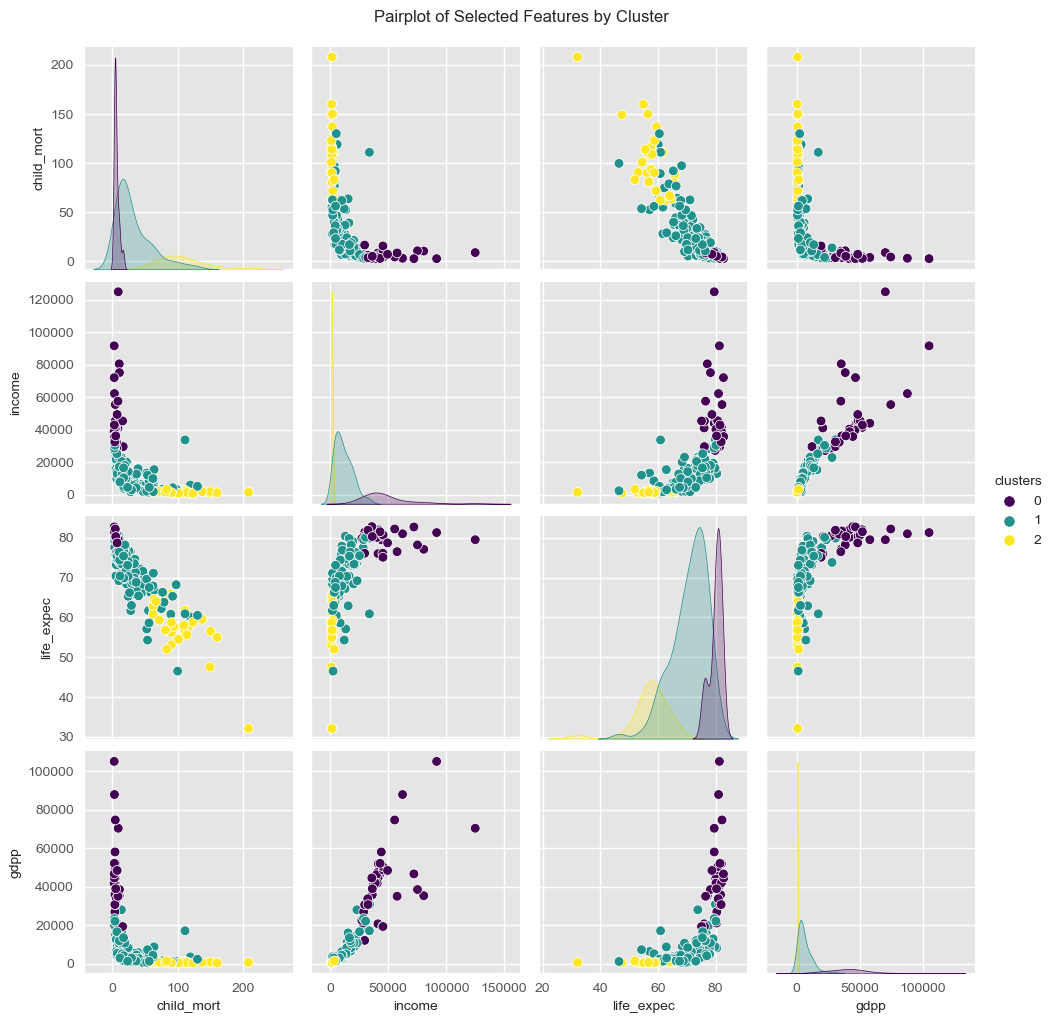

In [34]:
selected_features = ['child_mort', 'income', 'life_expec', 'gdpp']
sns.pairplot(data=df_hier, hue='clusters', vars=selected_features, palette='viridis')
plt.suptitle('Pairplot of Selected Features by Cluster', y=1.02)
plt.show()

In [35]:
df_hier['clusters'].loc[df_hier['clusters'] == 0] = 'Developed countries'
df_hier['clusters'].loc[df_hier['clusters'] == 1] = 'Developing countries'
df_hier['clusters'].loc[df_hier['clusters'] == 2] = 'Under-developed countries'

## kMeans Evaluation

In [36]:
fig = px.choropleth(df_kmeans[['country','clusters']],
                    locationmode = 'country names',
                    locations = 'country',
                    title = 'Rate of Development Per Country (kMeans)',
                    color = df_kmeans['clusters'], 
                    color_discrete_map = {'Under-developed countries':'Red',
                                        'Developed countries':'Green',
                                        'Developing countries':'Yellow'},
                    projection='natural earth'
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

## Hierarchical Clustering Evaluation

In [37]:
fig = px.choropleth(df_hier[['country','clusters']],
                    locationmode = 'country names',
                    locations = 'country',
                    title = 'Rate of Development Per Country (Hierarchical)',
                    color = df_hier['clusters'], 
                    color_discrete_map = {'Under-developed countries':'Red',
                                        'Developed countries':'Green',
                                        'Developing countries':'Yellow'},
                    projection='natural earth'
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

### Both ways seem to be a pretty good fit, close to the target presented below!

https://en.wikipedia.org/wiki/Developing_country#

![Image description](IMF_advanced_economies_and_UN_least_developed_countries-_1_.jpg)

## Now let's take a look at which countries have been clustered differently based on the above criteria

In [38]:
merge_df = pd.merge(df_hier,df_kmeans,on='country')
dif_clusters = merge_df[merge_df['clusters_x'] != merge_df['clusters_y']]
dif_clusters.rename(columns={'clusters_x': 'cluster_hier', 'clusters_y': 'cluster_kmeans'},inplace=True)

In [39]:
# Differently culstered countries between the two methods
dif_clusters[['country','cluster_hier','cluster_kmeans']].reset_index(drop=True)

country          cluster_hier             cluster_kmeans
0              Angola  Developing countries  Under-developed countries
1            Botswana  Developing countries  Under-developed countries
2         Congo, Rep.  Developing countries  Under-developed countries
3              Cyprus  Developing countries        Developed countries
4      Czech Republic  Developing countries        Developed countries
5   Equatorial Guinea  Developing countries  Under-developed countries
6             Eritrea  Developing countries  Under-developed countries
7               Gabon  Developing countries  Under-developed countries
8               Ghana  Developing countries  Under-developed countries
9                Iraq  Developing countries  Under-developed countries
10           Kiribati  Developing countries  Under-developed countries
11                Lao  Developing countries  Under-developed countries
12            Lesotho  Developing countries  Under-developed countries
13            Liberia  Developing countries  Under-developed countries
14              Libya   Developed countries       Developing countries
15         Mauritania  Developing countries  Under-developed countries
16            Namibia  Developing countries  Under-developed countries
17            Nigeria  Developing countries  Under-developed countries
18               Oman   Developed countries       Developing countries
19           Pakistan  Developing countries  Under-developed countries
20       Saudi Arabia   Developed countries       Developing countries
21    Slovak Republic  Developing countries        Developed countries
22           Slovenia  Developing countries        Developed countries
23       South Africa  Developing countries  Under-developed countries
24        South Korea  Developing countries        Developed countries
25              Sudan  Developing countries  Under-developed countries
26        Timor-Leste  Developing countries  Under-developed countries
27              Yemen  Developing countries  Under-developed countries

## Let's try Principal Component Analysis for Dimensionality Reduction

In [40]:
pca = PCA()
pc = pca.fit_transform(X)
ratio = pca.explained_variance_ratio_
sum_ratio = np.cumsum(np.round(ratio,2))
print(sum_ratio)
n = np.where(sum_ratio >.8) # here we try for 80%
n_components = n[0][0]
print("We can explain more than 80% of variance with any number of dimensions more than: ",n_components)

[0.46 0.63 0.76 0.87 0.94 0.96 0.97 0.98 0.99]
We can explain more than 80% of variance with any number of dimensions more than:  3


Text(0.5, 1.0, 'Explained Variance Ratio')

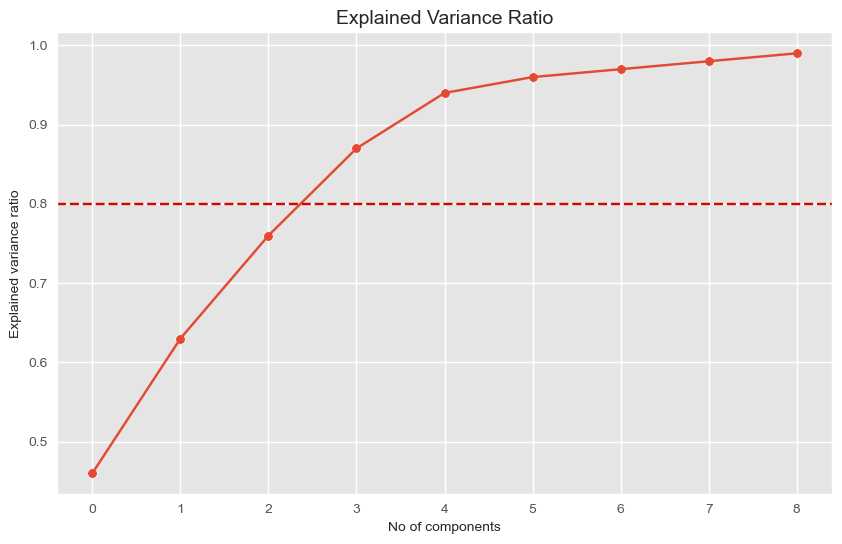

In [41]:
fig=plt.figure(figsize=(10,6))
ax=sns.lineplot(y=sum_ratio, x=np.arange(0,len(sum_ratio)))
ax=sns.scatterplot(y=sum_ratio, x=np.arange(0,len(sum_ratio)))
ax.set_xlabel('No of components')
ax.set_ylabel('Explained variance ratio')
ax.axhline(y=0.8, color='r', linestyle='--')
plt.title('Explained Variance Ratio',fontsize=14)

In [42]:
pca = PCA(n_components=2)
transformed = pd.DataFrame(pca.fit_transform(X))

Text(0, 0.5, 'Sum of squared errors')

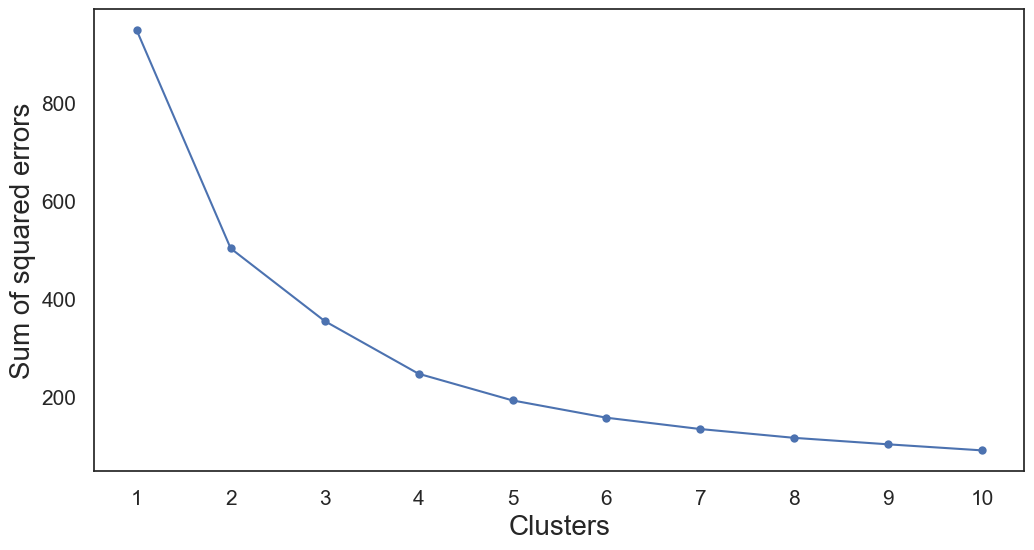

In [43]:
cluster_range = range( 1, 11 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( transformed )
    cluster_errors.append( clusters.inertia_ )
    
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_inertia": cluster_errors } )

sns.set(style="white")
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_inertia, marker = "o" )
plt.tick_params(labelsize=15)
plt.xticks(range(1, 11))
plt.xlabel("Clusters", fontsize=20)
plt.ylabel("Sum of squared errors", fontsize=20)

In [44]:
# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(transformed)
labels = kmeans.predict(transformed)
# Centroid values
C = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()

transformed['clusters'] = clusters

In [45]:
transformed.insert(0, 'country', df['country'])
transformed.rename(columns={0: 'x', 1: 'y'}, inplace=True)
transformed

country         x         y  clusters
0            Afghanistan -2.913025  0.095621         1
1                Albania  0.429911 -0.588156         0
2                Algeria -0.285225 -0.455174         0
3                 Angola -2.932423  1.695555         1
4    Antigua and Barbuda  1.033576  0.136659         0
..                   ...       ...       ...       ...
162              Vanuatu -0.820631  0.639570         1
163            Venezuela -0.551036 -1.233886         0
164              Vietnam  0.498524  1.390744         0
165                Yemen -1.887451 -0.109453         1
166               Zambia -2.864064  0.485998         1

[167 rows x 4 columns]

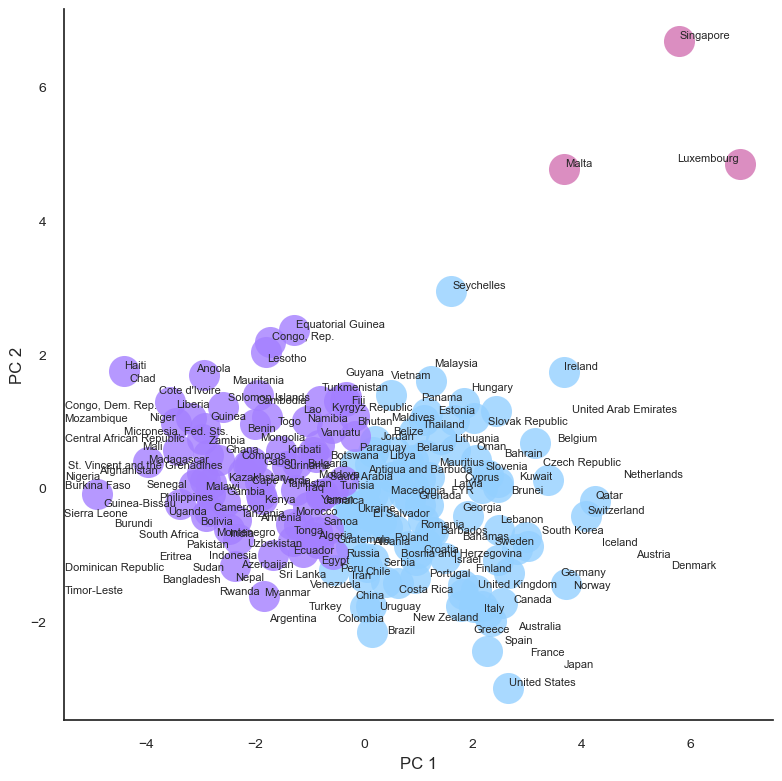

<Figure size 2000x2000 with 0 Axes>

In [46]:
import vapeplot
from adjustText import adjust_text

sns.set(style="white")
pal =  sns.blend_palette(vapeplot.palette('vaporwave'))

sns.lmplot(x="x", y="y",hue='clusters', data=transformed, legend=False,
                   fit_reg=False, height=8, scatter_kws={"s": 500}, palette=pal)

texts = []
for x, y, s in zip(transformed.x, transformed.y, transformed.country):
    texts.append(plt.text(x, y, s,fontsize=8))
adjust_text(texts) #, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))  # uncomment to add arrows to labels

plt.tick_params(labelsize=10)
#plt.setp(ax.get_legend().get_title(), fontsize='15')
plt.xlabel("PC 1", fontsize=12)
plt.ylabel("PC 2", fontsize=12)
plt.figure(figsize=(20, 20))
plt.show()
# ax.savefig("pc_kmeans.jpg")

## Let's try with 3 components

In [53]:
pca = PCA(n_components=3)
X_sc = pca.fit_transform(X)
tran_3 = pd.DataFrame(X_sc)

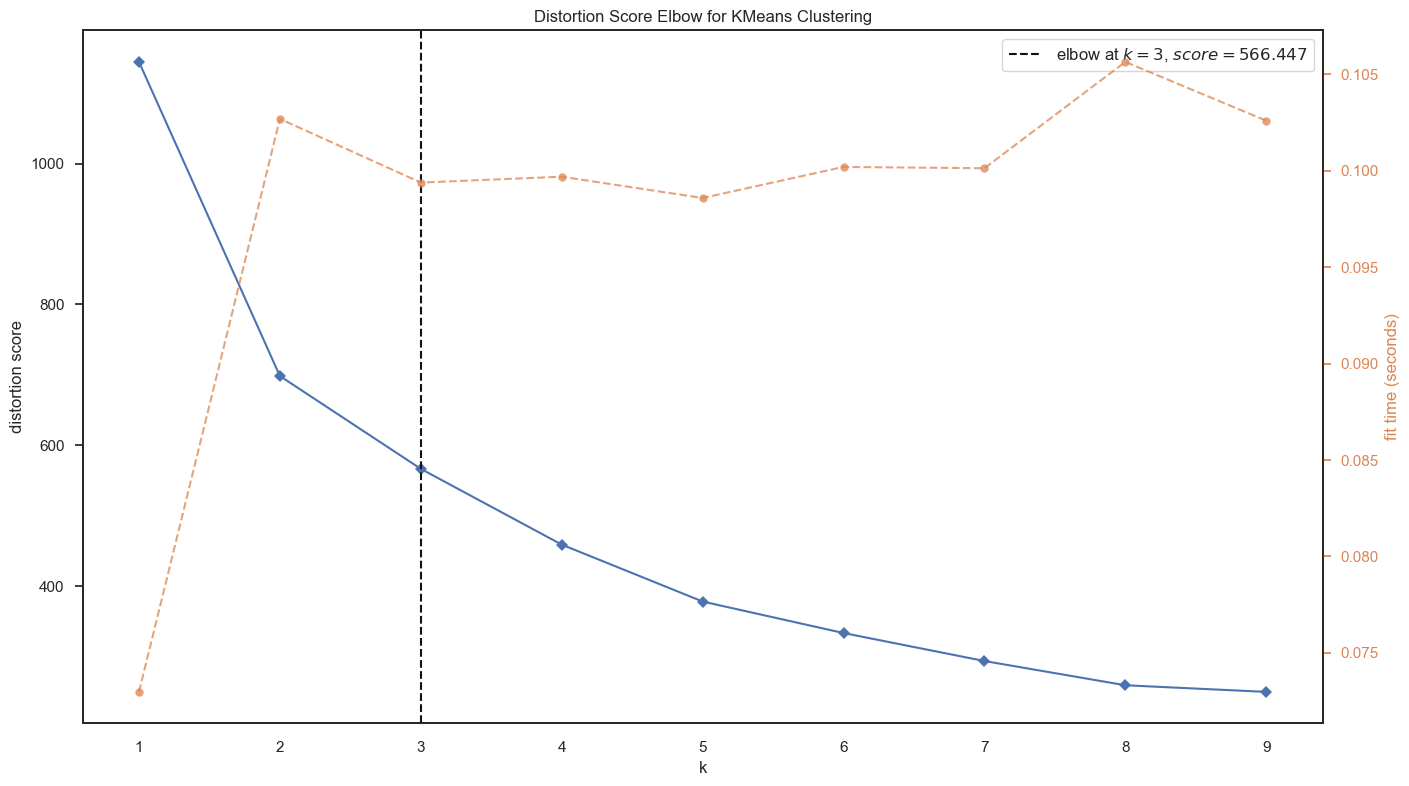

In [56]:
# Instantiate the clustering model and visualizer
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(1,10), locate_elbow=True)

visualizer.fit(tran_3)    # Fit the data to the visualizer
visualizer.poof()        # Draw/show/poof the data
plt.show()

In [57]:
# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(tran_3)
labels = kmeans.predict(tran_3)
# Centroid values
C = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()

tran_3['clusters'] = clusters

In [58]:
tran_3.insert(0, 'country', df['country'])
tran_3.rename(columns={0: 'x', 1: 'y',2:'z'}, inplace=True)

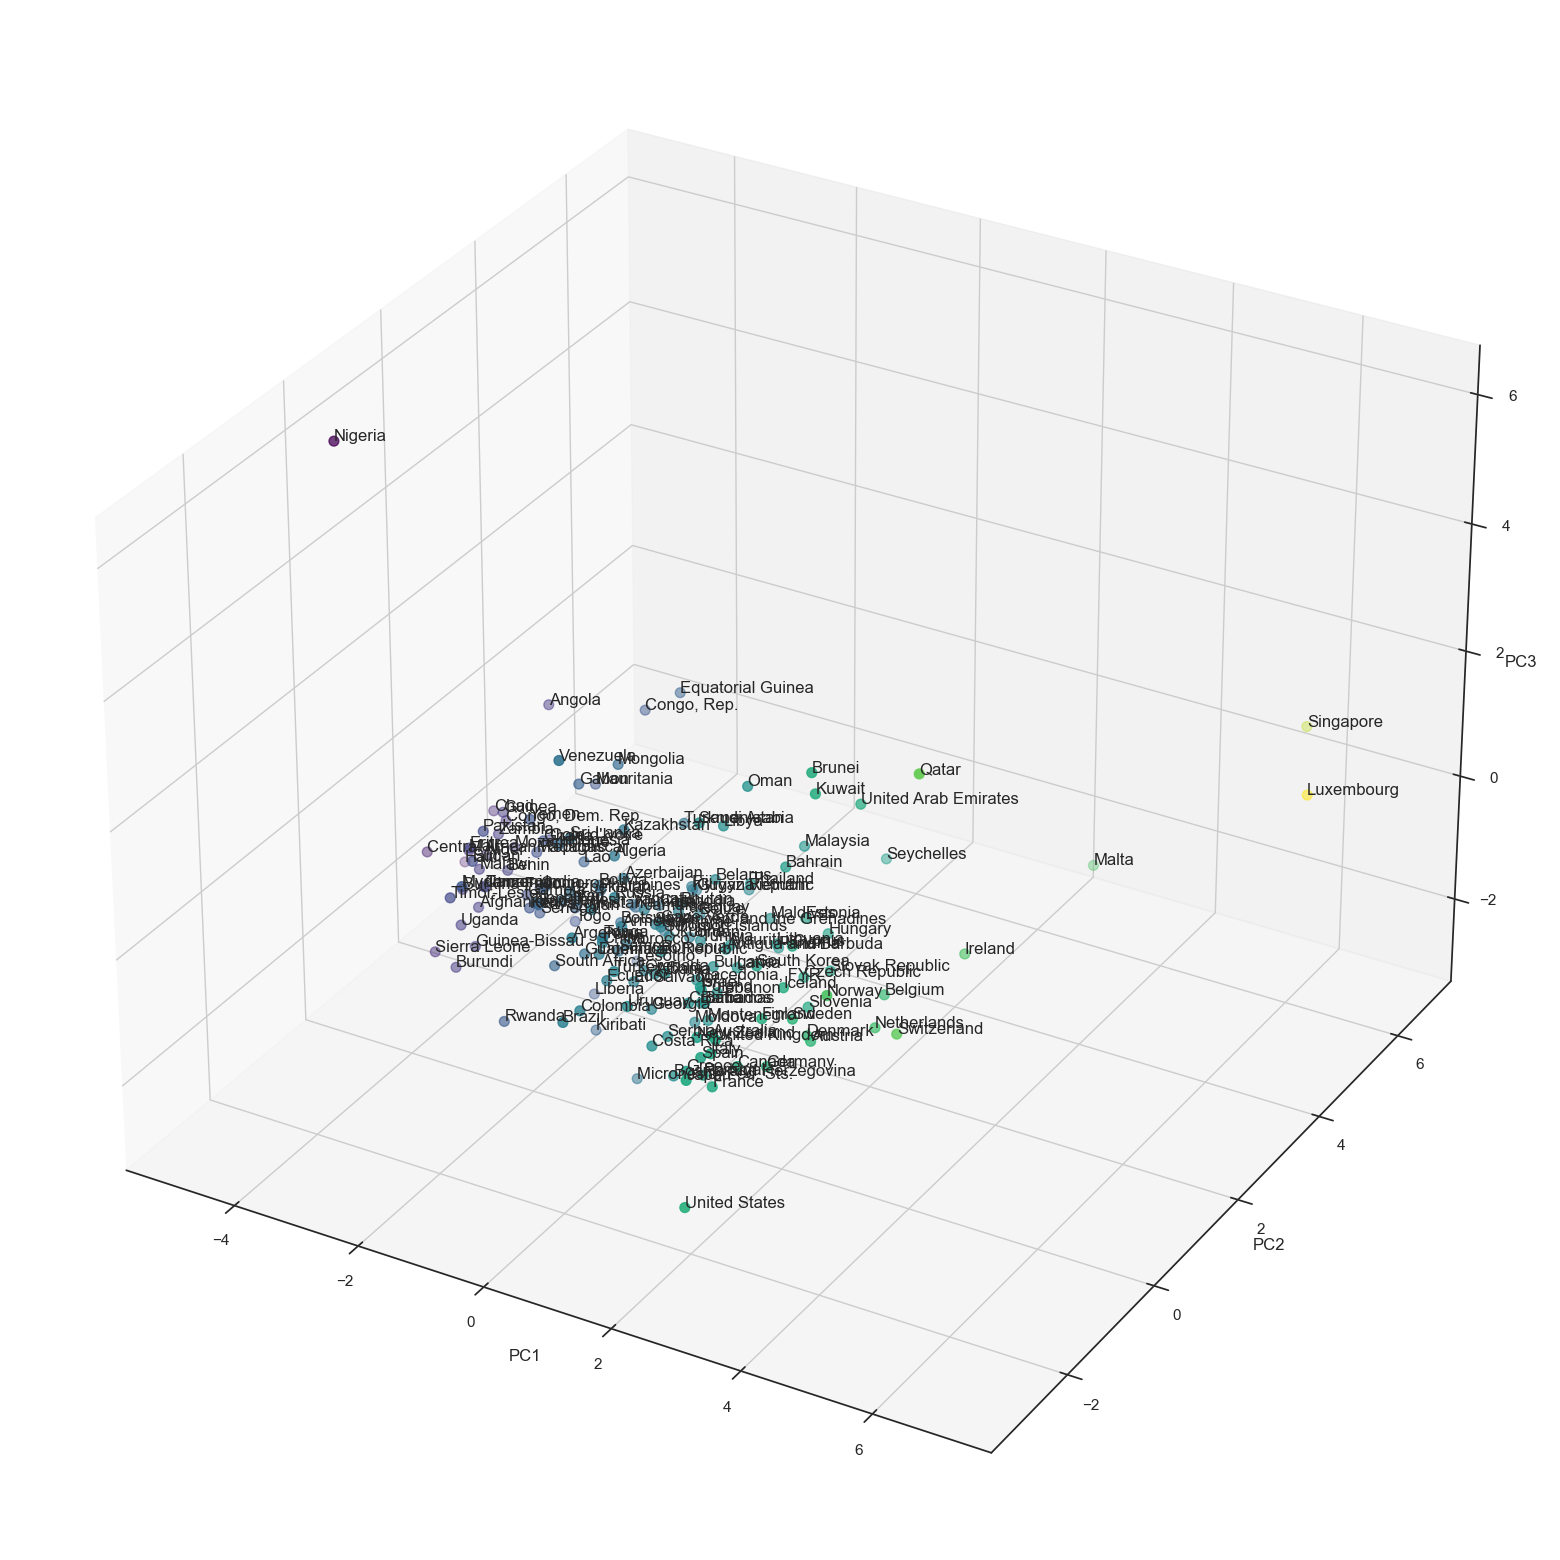

In [59]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(tran_3['x'], tran_3['y'], tran_3['z'],
            c=tran_3['x'],cmap='viridis', s=50)

# Annotating each point with the corresponding country name
for i, country in enumerate(tran_3['country']):
    ax.text(tran_3['x'].iloc[i], tran_3['y'].iloc[i], tran_3['z'].iloc[i], country)


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


plt.show()

## Final Remarks & Conclusion

This project focused on applying Unsupervised Machine Learning Algorithms mainly using Principal Component Analysis(PCA), k-Means and Hierarchical Clustering to find the best number of clusters for the countries. The best fit proved to be three clusters of countries with different socio-economic and health factors.
- Under-developed countries: Low income, GDP per capita, high child mortality,low health expenditure, low life expectancy
- Developed countries: High income, GDP per capita, low child mortality, low health expenditure, high life expectancy
- Developing countries: Placed between the under-developed countries(low economy - health) & the developed countries (high economy - health)

This dataset fits pretty good to the clustering created and close to the reality as shown in the Wikipedia photo. Further development of this project could be to merge this table with new features for each countries and develop also other factors that may change the level of development of each country. Also, more clustering algorithms like DBSCAN and Gaussian Clustering can be used and compare the final results.